In [1]:
import random

import numpy as np
import random
import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras import models
from keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# number of characters in a word.
# for instance abccba has nb_chars = 6
nb_chars = 5

# number of possible characters used during the encoding.
# for instance abcde leads to 01234 has nb_letters = 5
nb_letters = 26

# number of words samples to be generated 
nb_words = 40000

# percentage of words that will be used for validation
percentage_split = 0.90

In [3]:
# total number of combinations
nb_letters**nb_chars

11881376

In [4]:
def create_inputs(nb_words, nb_chars, nb_letters):
    '''Create a numpy array of nb_words rows with nb_chars columns each element
    being a random letter of nb_letters (a, b...)'''
    words = np.zeros((nb_words, nb_chars), dtype=int)
    for w in range(nb_words):
        for c in range(nb_chars):
            i = random.randint(0, nb_letters-1)
            words[w, c] = ord('a') + i
    return words


def encrypt(words, nb_words, nb_chars):
    '''Encrypt each element of a numpy array of nb_words rows with nb_chars 
    columns each item with a secret algorithm'''
    
    encrypted_words = words.copy()
    encrypted_words_probs = np.zeros((nb_words, nb_chars, nb_chars))
    
    #val_max = -1
    
    for w in range(nb_words):
        for c in range(nb_chars): # 0,1,2,3,4
            encrypted_words[w,c] = int(words[w,c]) - 49
            val = encrypted_words[w,c] - 48
            
            #if val > val_max:
            #    val_max = val
            
            # add entropy (i.e. mistakes in the encryption)
            #epsilon = random.randint(0, 100)
            #if epsilon == 5 and val != val_max:
            #val +=1
            
            #print('w:',w,', c:',c,', [wc]:', val)
            #encrypted_words_probs[w, c, val ] = 1.0
            encrypted_words[w,c] = val
    return encrypted_words

def print_output(words, nb_words, nb_chars):
    for w in range(nb_words):
        word = ''
        for c in range(nb_chars):
            word += chr(words[w,c])
        print(word)


In [5]:
nb_features = nb_chars

# This returns a tensor
inputs = layers.Input(shape=(nb_chars,), dtype='float32', name='main_input')

# a layer instance is callable on a tensor, and returns a tensor
x = layers.Dense(4096, activation='relu', name='hl_1')(inputs)
#x = layers.Dense(2048, activation='relu', name='hl_1')(inputs)
#x = layers.Dense(64, activation='relu', name='hl_2')(x)

outputs = []
losses = {}
for o in range(nb_chars):
    name_i = 'output_'+str(o)
    output_i = layers.Dense(nb_letters, activation='softmax', dtype='float32', name=name_i)(x)
    outputs.append(output_i)
    losses[name_i] = 'categorical_crossentropy'

coding_model = keras.models.Model(inputs=inputs, outputs=outputs)

coding_model.compile(optimizer='rmsprop',
                     loss=losses,
                     metrics=['accuracy'])       

In [6]:
print(coding_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 5)            0                                            
__________________________________________________________________________________________________
hl_1 (Dense)                    (None, 4096)         24576       main_input[0][0]                 
__________________________________________________________________________________________________
output_0 (Dense)                (None, 26)           106522      hl_1[0][0]                       
__________________________________________________________________________________________________
output_1 (Dense)                (None, 26)           106522      hl_1[0][0]                       
__________________________________________________________________________________________________
output_2 (

In [7]:
def display_x(x):
    words = []
    for w in x:
        word = ''
        for c in w:
            word += chr(c)
        words.append(word)
   
    print(words)

In [8]:
# ALL IN ONE STEP ('OSSIFIED')

x = create_inputs(nb_words, nb_chars, nb_letters)
display_x(x[:3])
print('x:\n', x[:3], 'out of ',len(x))
print()

# process the x data as useful ANN input data
scaler = StandardScaler()
x_train  = scaler.fit_transform(x)

print('x_train:\n', x_train[:3], 'out of ',len(x_train))
print()

# create output data for training
y = encrypt(x, nb_words, nb_chars)
print('y:\n', y)
print()
# process the y data as useful ANN output data
y_train = keras.utils.to_categorical(y, nb_letters)
print('y_train:\n', y_train[:3], 'out of ',len(y_train))

['jglvv', 'azwnb', 'jdooq']
x:
 [[106 103 108 118 118]
 [ 97 122 119 110  98]
 [106 100 111 111 113]] out of  40000

x_train:
 [[-0.46690356 -0.87039335 -0.20371252  1.13356004  1.13372881]
 [-1.66938515  1.65680395  1.26052841  0.06642891 -1.5336801 ]
 [-0.46690356 -1.2694245   0.19562592  0.1998203   0.46687658]] out of  40000

y:
 [[ 9  6 11 21 21]
 [ 0 25 22 13  1]
 [ 9  3 14 14 16]
 ...
 [ 1 21  6 23  5]
 [21 17  6  9 14]
 [ 8  5  0 16 18]]

y_train:
 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
   0. 0. 0.]]

 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
def get_sub_sub_set(y, c_ref, nb_chars):
    '''Retrieve the probalities of the i-th char'''
    nb_samples = len(y)
    
    yi = np.zeros((nb_samples, nb_letters), dtype=int)
    
    for s in range(nb_samples):
        for c in range(nb_chars):
            #print('ysl:',y[s][0][l_i])
            if c == c_ref:
                yi[s] = y[s, c]
                
    return yi

In [10]:
y_train2 = []
for c in range(nb_chars):
    yi_train = get_sub_sub_set(y_train, c, nb_chars)
    y_train2.append(yi_train)

In [11]:
y_train2[:3]

[array([[0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]])]

In [12]:
history = coding_model.fit(x_train, y_train2, validation_split=percentage_split, epochs=1000, verbose=1)

Train on 3999 samples, validate on 36001 samples
Epoch 1/1000
3999/3999 [==============================] - 3s 664us/step - loss: 13.1663 - output_0_loss: 2.6201 - output_1_loss: 2.6320 - output_2_loss: 2.6331 - output_3_loss: 2.6467 - output_4_loss: 2.6344 - output_0_acc: 0.1555 - output_1_acc: 0.1395 - output_2_acc: 0.1433 - output_3_acc: 0.1403 - output_4_acc: 0.1435 - val_loss: 11.7446 - val_output_0_loss: 2.3729 - val_output_1_loss: 2.3459 - val_output_2_loss: 2.3286 - val_output_3_loss: 2.3395 - val_output_4_loss: 2.3578 - val_output_0_acc: 0.1892 - val_output_1_acc: 0.1730 - val_output_2_acc: 0.1827 - val_output_3_acc: 0.1827 - val_output_4_acc: 0.1776
Epoch 2/1000
3999/3999 [==============================] - 2s 540us/step - loss: 10.9970 - output_0_loss: 2.1819 - output_1_loss: 2.1951 - output_2_loss: 2.2057 - output_3_loss: 2.2144 - output_4_loss: 2.1999 - output_0_acc: 0.2326 - output_1_acc: 0.2133 - output_2_acc: 0.2153 - output_3_acc: 0.2058 - output_4_acc: 0.2118 - val_loss

3999/3999 [==============================] - 2s 511us/step - loss: 6.4846 - output_0_loss: 1.2991 - output_1_loss: 1.2968 - output_2_loss: 1.2891 - output_3_loss: 1.2922 - output_4_loss: 1.3074 - output_0_acc: 0.4904 - output_1_acc: 0.4819 - output_2_acc: 0.4824 - output_3_acc: 0.4886 - output_4_acc: 0.4819 - val_loss: 6.8435 - val_output_0_loss: 1.4173 - val_output_1_loss: 1.3655 - val_output_2_loss: 1.3884 - val_output_3_loss: 1.3377 - val_output_4_loss: 1.3346 - val_output_0_acc: 0.4114 - val_output_1_acc: 0.4498 - val_output_2_acc: 0.4575 - val_output_3_acc: 0.4465 - val_output_4_acc: 0.4408
Epoch 15/1000
3999/3999 [==============================] - 2s 512us/step - loss: 6.2858 - output_0_loss: 1.2623 - output_1_loss: 1.2566 - output_2_loss: 1.2416 - output_3_loss: 1.2552 - output_4_loss: 1.2701 - output_0_acc: 0.4989 - output_1_acc: 0.4981 - output_2_acc: 0.5114 - output_3_acc: 0.5021 - output_4_acc: 0.5001 - val_loss: 6.6599 - val_output_0_loss: 1.3270 - val_output_1_loss: 1.3256

3999/3999 [==============================] - 2s 532us/step - loss: 4.6608 - output_0_loss: 0.9414 - output_1_loss: 0.9299 - output_2_loss: 0.9248 - output_3_loss: 0.9310 - output_4_loss: 0.9337 - output_0_acc: 0.6352 - output_1_acc: 0.6379 - output_2_acc: 0.6319 - output_3_acc: 0.6312 - output_4_acc: 0.6309 - val_loss: 5.2503 - val_output_0_loss: 1.0873 - val_output_1_loss: 1.0333 - val_output_2_loss: 1.0661 - val_output_3_loss: 0.9922 - val_output_4_loss: 1.0714 - val_output_0_acc: 0.5490 - val_output_1_acc: 0.5747 - val_output_2_acc: 0.5545 - val_output_3_acc: 0.5909 - val_output_4_acc: 0.5416
Epoch 28/1000
3999/3999 [==============================] - 2s 503us/step - loss: 4.5618 - output_0_loss: 0.9227 - output_1_loss: 0.9052 - output_2_loss: 0.9105 - output_3_loss: 0.9046 - output_4_loss: 0.9188 - output_0_acc: 0.6374 - output_1_acc: 0.6562 - output_2_acc: 0.6432 - output_3_acc: 0.6442 - output_4_acc: 0.6402 - val_loss: 5.2793 - val_output_0_loss: 1.0352 - val_output_1_loss: 1.0759

3999/3999 [==============================] - 2s 501us/step - loss: 3.5779 - output_0_loss: 0.7322 - output_1_loss: 0.7034 - output_2_loss: 0.7112 - output_3_loss: 0.7125 - output_4_loss: 0.7185 - output_0_acc: 0.7219 - output_1_acc: 0.7402 - output_2_acc: 0.7294 - output_3_acc: 0.7407 - output_4_acc: 0.7252 - val_loss: 4.0615 - val_output_0_loss: 0.8058 - val_output_1_loss: 0.8288 - val_output_2_loss: 0.7568 - val_output_3_loss: 0.8178 - val_output_4_loss: 0.8523 - val_output_0_acc: 0.6742 - val_output_1_acc: 0.6813 - val_output_2_acc: 0.7251 - val_output_3_acc: 0.6553 - val_output_4_acc: 0.6587
Epoch 41/1000
3999/3999 [==============================] - 2s 499us/step - loss: 3.5051 - output_0_loss: 0.7154 - output_1_loss: 0.7020 - output_2_loss: 0.6945 - output_3_loss: 0.6965 - output_4_loss: 0.6967 - output_0_acc: 0.7339 - output_1_acc: 0.7382 - output_2_acc: 0.7394 - output_3_acc: 0.7464 - output_4_acc: 0.7422 - val_loss: 4.0944 - val_output_0_loss: 0.8060 - val_output_1_loss: 0.7811

3999/3999 [==============================] - 2s 492us/step - loss: 2.8100 - output_0_loss: 0.5792 - output_1_loss: 0.5604 - output_2_loss: 0.5589 - output_3_loss: 0.5527 - output_4_loss: 0.5588 - output_0_acc: 0.7929 - output_1_acc: 0.8065 - output_2_acc: 0.8167 - output_3_acc: 0.8160 - output_4_acc: 0.8075 - val_loss: 3.4674 - val_output_0_loss: 0.6850 - val_output_1_loss: 0.7441 - val_output_2_loss: 0.6491 - val_output_3_loss: 0.6366 - val_output_4_loss: 0.7525 - val_output_0_acc: 0.7463 - val_output_1_acc: 0.7162 - val_output_2_acc: 0.7565 - val_output_3_acc: 0.7761 - val_output_4_acc: 0.6973
Epoch 54/1000
3999/3999 [==============================] - 2s 499us/step - loss: 2.7701 - output_0_loss: 0.5694 - output_1_loss: 0.5459 - output_2_loss: 0.5489 - output_3_loss: 0.5482 - output_4_loss: 0.5577 - output_0_acc: 0.8042 - output_1_acc: 0.8137 - output_2_acc: 0.8157 - output_3_acc: 0.8132 - output_4_acc: 0.8102 - val_loss: 3.5061 - val_output_0_loss: 0.7306 - val_output_1_loss: 0.6691

3999/3999 [==============================] - 2s 482us/step - loss: 2.2317 - output_0_loss: 0.4660 - output_1_loss: 0.4430 - output_2_loss: 0.4397 - output_3_loss: 0.4355 - output_4_loss: 0.4475 - output_0_acc: 0.8475 - output_1_acc: 0.8645 - output_2_acc: 0.8610 - output_3_acc: 0.8715 - output_4_acc: 0.8660 - val_loss: 2.9625 - val_output_0_loss: 0.6404 - val_output_1_loss: 0.6241 - val_output_2_loss: 0.5734 - val_output_3_loss: 0.5207 - val_output_4_loss: 0.6039 - val_output_0_acc: 0.7555 - val_output_1_acc: 0.7412 - val_output_2_acc: 0.7952 - val_output_3_acc: 0.8261 - val_output_4_acc: 0.7650
Epoch 67/1000
3999/3999 [==============================] - 2s 484us/step - loss: 2.1803 - output_0_loss: 0.4459 - output_1_loss: 0.4363 - output_2_loss: 0.4234 - output_3_loss: 0.4322 - output_4_loss: 0.4426 - output_0_acc: 0.8567 - output_1_acc: 0.8617 - output_2_acc: 0.8700 - output_3_acc: 0.8677 - output_4_acc: 0.8642 - val_loss: 2.8969 - val_output_0_loss: 0.6033 - val_output_1_loss: 0.5512

3999/3999 [==============================] - 2s 424us/step - loss: 1.7658 - output_0_loss: 0.3733 - output_1_loss: 0.3454 - output_2_loss: 0.3470 - output_3_loss: 0.3418 - output_4_loss: 0.3584 - output_0_acc: 0.8890 - output_1_acc: 0.9037 - output_2_acc: 0.9047 - output_3_acc: 0.9120 - output_4_acc: 0.8967 - val_loss: 2.2854 - val_output_0_loss: 0.5305 - val_output_1_loss: 0.4140 - val_output_2_loss: 0.4640 - val_output_3_loss: 0.4010 - val_output_4_loss: 0.4758 - val_output_0_acc: 0.7967 - val_output_1_acc: 0.8874 - val_output_2_acc: 0.8509 - val_output_3_acc: 0.9020 - val_output_4_acc: 0.8515
Epoch 80/1000
3999/3999 [==============================] - 2s 438us/step - loss: 1.7408 - output_0_loss: 0.3614 - output_1_loss: 0.3434 - output_2_loss: 0.3379 - output_3_loss: 0.3387 - output_4_loss: 0.3593 - output_0_acc: 0.8965 - output_1_acc: 0.9052 - output_2_acc: 0.9092 - output_3_acc: 0.9117 - output_4_acc: 0.8990 - val_loss: 2.4907 - val_output_0_loss: 0.5404 - val_output_1_loss: 0.5454

3999/3999 [==============================] - 2s 482us/step - loss: 1.4090 - output_0_loss: 0.3002 - output_1_loss: 0.2805 - output_2_loss: 0.2763 - output_3_loss: 0.2675 - output_4_loss: 0.2845 - output_0_acc: 0.9162 - output_1_acc: 0.9270 - output_2_acc: 0.9310 - output_3_acc: 0.9345 - output_4_acc: 0.9205 - val_loss: 2.1746 - val_output_0_loss: 0.3973 - val_output_1_loss: 0.3774 - val_output_2_loss: 0.4436 - val_output_3_loss: 0.4078 - val_output_4_loss: 0.5486 - val_output_0_acc: 0.8723 - val_output_1_acc: 0.8862 - val_output_2_acc: 0.8443 - val_output_3_acc: 0.8509 - val_output_4_acc: 0.7820
Epoch 93/1000
3999/3999 [==============================] - 2s 480us/step - loss: 1.3908 - output_0_loss: 0.2957 - output_1_loss: 0.2669 - output_2_loss: 0.2731 - output_3_loss: 0.2660 - output_4_loss: 0.2892 - output_0_acc: 0.9237 - output_1_acc: 0.9367 - output_2_acc: 0.9357 - output_3_acc: 0.9375 - output_4_acc: 0.9215 - val_loss: 2.0230 - val_output_0_loss: 0.4145 - val_output_1_loss: 0.4050

3999/3999 [==============================] - 2s 519us/step - loss: 1.1082 - output_0_loss: 0.2414 - output_1_loss: 0.2162 - output_2_loss: 0.2141 - output_3_loss: 0.2090 - output_4_loss: 0.2275 - output_0_acc: 0.9422 - output_1_acc: 0.9545 - output_2_acc: 0.9527 - output_3_acc: 0.9555 - output_4_acc: 0.9457 - val_loss: 1.7535 - val_output_0_loss: 0.3543 - val_output_1_loss: 0.3011 - val_output_2_loss: 0.3435 - val_output_3_loss: 0.4251 - val_output_4_loss: 0.3295 - val_output_0_acc: 0.8788 - val_output_1_acc: 0.9176 - val_output_2_acc: 0.8868 - val_output_3_acc: 0.8297 - val_output_4_acc: 0.9068
Epoch 106/1000
3999/3999 [==============================] - 2s 515us/step - loss: 1.0985 - output_0_loss: 0.2385 - output_1_loss: 0.2128 - output_2_loss: 0.2154 - output_3_loss: 0.2064 - output_4_loss: 0.2254 - output_0_acc: 0.9397 - output_1_acc: 0.9530 - output_2_acc: 0.9487 - output_3_acc: 0.9555 - output_4_acc: 0.9487 - val_loss: 1.6924 - val_output_0_loss: 0.3817 - val_output_1_loss: 0.297

3999/3999 [==============================] - 2s 518us/step - loss: 0.8763 - output_0_loss: 0.1926 - output_1_loss: 0.1669 - output_2_loss: 0.1688 - output_3_loss: 0.1640 - output_4_loss: 0.1841 - output_0_acc: 0.9567 - output_1_acc: 0.9680 - output_2_acc: 0.9660 - output_3_acc: 0.9725 - output_4_acc: 0.9590 - val_loss: 1.4208 - val_output_0_loss: 0.2815 - val_output_1_loss: 0.3275 - val_output_2_loss: 0.2595 - val_output_3_loss: 0.2586 - val_output_4_loss: 0.2938 - val_output_0_acc: 0.9125 - val_output_1_acc: 0.8815 - val_output_2_acc: 0.9332 - val_output_3_acc: 0.9293 - val_output_4_acc: 0.9123
Epoch 119/1000
3999/3999 [==============================] - 2s 508us/step - loss: 0.8673 - output_0_loss: 0.1874 - output_1_loss: 0.1684 - output_2_loss: 0.1675 - output_3_loss: 0.1630 - output_4_loss: 0.1810 - output_0_acc: 0.9580 - output_1_acc: 0.9642 - output_2_acc: 0.9640 - output_3_acc: 0.9702 - output_4_acc: 0.9590 - val_loss: 1.3655 - val_output_0_loss: 0.3192 - val_output_1_loss: 0.275

3999/3999 [==============================] - 2s 492us/step - loss: 0.6952 - output_0_loss: 0.1542 - output_1_loss: 0.1347 - output_2_loss: 0.1334 - output_3_loss: 0.1296 - output_4_loss: 0.1432 - output_0_acc: 0.9685 - output_1_acc: 0.9765 - output_2_acc: 0.9755 - output_3_acc: 0.9780 - output_4_acc: 0.9700 - val_loss: 1.2158 - val_output_0_loss: 0.2480 - val_output_1_loss: 0.2436 - val_output_2_loss: 0.2364 - val_output_3_loss: 0.1902 - val_output_4_loss: 0.2977 - val_output_0_acc: 0.9328 - val_output_1_acc: 0.9298 - val_output_2_acc: 0.9262 - val_output_3_acc: 0.9641 - val_output_4_acc: 0.9005
Epoch 132/1000
3999/3999 [==============================] - 2s 491us/step - loss: 0.6715 - output_0_loss: 0.1501 - output_1_loss: 0.1284 - output_2_loss: 0.1286 - output_3_loss: 0.1212 - output_4_loss: 0.1431 - output_0_acc: 0.9680 - output_1_acc: 0.9760 - output_2_acc: 0.9765 - output_3_acc: 0.9835 - output_4_acc: 0.9702 - val_loss: 1.2388 - val_output_0_loss: 0.2940 - val_output_1_loss: 0.221

3999/3999 [==============================] - 2s 496us/step - loss: 0.5414 - output_0_loss: 0.1253 - output_1_loss: 0.1008 - output_2_loss: 0.1036 - output_3_loss: 0.0978 - output_4_loss: 0.1139 - output_0_acc: 0.9750 - output_1_acc: 0.9827 - output_2_acc: 0.9817 - output_3_acc: 0.9870 - output_4_acc: 0.9785 - val_loss: 1.0520 - val_output_0_loss: 0.2047 - val_output_1_loss: 0.1878 - val_output_2_loss: 0.2213 - val_output_3_loss: 0.1781 - val_output_4_loss: 0.2600 - val_output_0_acc: 0.9449 - val_output_1_acc: 0.9467 - val_output_2_acc: 0.9352 - val_output_3_acc: 0.9526 - val_output_4_acc: 0.9144
Epoch 145/1000
3999/3999 [==============================] - 2s 523us/step - loss: 0.5366 - output_0_loss: 0.1240 - output_1_loss: 0.1005 - output_2_loss: 0.1010 - output_3_loss: 0.0940 - output_4_loss: 0.1170 - output_0_acc: 0.9732 - output_1_acc: 0.9817 - output_2_acc: 0.9830 - output_3_acc: 0.9867 - output_4_acc: 0.9760 - val_loss: 0.9178 - val_output_0_loss: 0.2183 - val_output_1_loss: 0.174

3999/3999 [==============================] - 2s 516us/step - loss: 0.4173 - output_0_loss: 0.0965 - output_1_loss: 0.0785 - output_2_loss: 0.0817 - output_3_loss: 0.0705 - output_4_loss: 0.0901 - output_0_acc: 0.9820 - output_1_acc: 0.9870 - output_2_acc: 0.9875 - output_3_acc: 0.9935 - output_4_acc: 0.9842 - val_loss: 0.9124 - val_output_0_loss: 0.2434 - val_output_1_loss: 0.1542 - val_output_2_loss: 0.1372 - val_output_3_loss: 0.1980 - val_output_4_loss: 0.1796 - val_output_0_acc: 0.9119 - val_output_1_acc: 0.9619 - val_output_2_acc: 0.9671 - val_output_3_acc: 0.9450 - val_output_4_acc: 0.9531
Epoch 158/1000
3999/3999 [==============================] - 2s 478us/step - loss: 0.4203 - output_0_loss: 0.0991 - output_1_loss: 0.0796 - output_2_loss: 0.0755 - output_3_loss: 0.0746 - output_4_loss: 0.0914 - output_0_acc: 0.9815 - output_1_acc: 0.9890 - output_2_acc: 0.9872 - output_3_acc: 0.9922 - output_4_acc: 0.9807 - val_loss: 0.7452 - val_output_0_loss: 0.1687 - val_output_1_loss: 0.129

3999/3999 [==============================] - 2s 485us/step - loss: 0.3240 - output_0_loss: 0.0756 - output_1_loss: 0.0581 - output_2_loss: 0.0604 - output_3_loss: 0.0552 - output_4_loss: 0.0746 - output_0_acc: 0.9882 - output_1_acc: 0.9960 - output_2_acc: 0.9917 - output_3_acc: 0.9952 - output_4_acc: 0.9867 - val_loss: 0.6583 - val_output_0_loss: 0.1539 - val_output_1_loss: 0.1213 - val_output_2_loss: 0.1351 - val_output_3_loss: 0.1208 - val_output_4_loss: 0.1272 - val_output_0_acc: 0.9610 - val_output_1_acc: 0.9764 - val_output_2_acc: 0.9694 - val_output_3_acc: 0.9730 - val_output_4_acc: 0.9709
Epoch 171/1000
3999/3999 [==============================] - 2s 497us/step - loss: 0.3212 - output_0_loss: 0.0775 - output_1_loss: 0.0604 - output_2_loss: 0.0582 - output_3_loss: 0.0556 - output_4_loss: 0.0694 - output_0_acc: 0.9895 - output_1_acc: 0.9907 - output_2_acc: 0.9925 - output_3_acc: 0.9955 - output_4_acc: 0.9887 - val_loss: 0.6908 - val_output_0_loss: 0.1700 - val_output_1_loss: 0.111

3999/3999 [==============================] - 2s 503us/step - loss: 0.2570 - output_0_loss: 0.0623 - output_1_loss: 0.0482 - output_2_loss: 0.0449 - output_3_loss: 0.0450 - output_4_loss: 0.0566 - output_0_acc: 0.9885 - output_1_acc: 0.9952 - output_2_acc: 0.9950 - output_3_acc: 0.9952 - output_4_acc: 0.9907 - val_loss: 0.5868 - val_output_0_loss: 0.1273 - val_output_1_loss: 0.0995 - val_output_2_loss: 0.0936 - val_output_3_loss: 0.1215 - val_output_4_loss: 0.1448 - val_output_0_acc: 0.9662 - val_output_1_acc: 0.9807 - val_output_2_acc: 0.9811 - val_output_3_acc: 0.9694 - val_output_4_acc: 0.9564
Epoch 184/1000
3999/3999 [==============================] - 2s 480us/step - loss: 0.2553 - output_0_loss: 0.0622 - output_1_loss: 0.0488 - output_2_loss: 0.0459 - output_3_loss: 0.0430 - output_4_loss: 0.0553 - output_0_acc: 0.9887 - output_1_acc: 0.9932 - output_2_acc: 0.9942 - output_3_acc: 0.9957 - output_4_acc: 0.9930 - val_loss: 0.5731 - val_output_0_loss: 0.1423 - val_output_1_loss: 0.081

3999/3999 [==============================] - 2s 488us/step - loss: 0.1975 - output_0_loss: 0.0467 - output_1_loss: 0.0354 - output_2_loss: 0.0350 - output_3_loss: 0.0336 - output_4_loss: 0.0469 - output_0_acc: 0.9952 - output_1_acc: 0.9967 - output_2_acc: 0.9962 - output_3_acc: 0.9970 - output_4_acc: 0.9932 - val_loss: 0.5061 - val_output_0_loss: 0.1379 - val_output_1_loss: 0.0995 - val_output_2_loss: 0.1013 - val_output_3_loss: 0.0671 - val_output_4_loss: 0.1003 - val_output_0_acc: 0.9611 - val_output_1_acc: 0.9753 - val_output_2_acc: 0.9726 - val_output_3_acc: 0.9881 - val_output_4_acc: 0.9794
Epoch 197/1000
3999/3999 [==============================] - 2s 511us/step - loss: 0.1911 - output_0_loss: 0.0486 - output_1_loss: 0.0353 - output_2_loss: 0.0334 - output_3_loss: 0.0332 - output_4_loss: 0.0406 - output_0_acc: 0.9927 - output_1_acc: 0.9977 - output_2_acc: 0.9970 - output_3_acc: 0.9975 - output_4_acc: 0.9967 - val_loss: 0.4964 - val_output_0_loss: 0.1383 - val_output_1_loss: 0.101

3999/3999 [==============================] - 2s 460us/step - loss: 0.1583 - output_0_loss: 0.0398 - output_1_loss: 0.0262 - output_2_loss: 0.0283 - output_3_loss: 0.0269 - output_4_loss: 0.0371 - output_0_acc: 0.9942 - output_1_acc: 0.9977 - output_2_acc: 0.9977 - output_3_acc: 0.9980 - output_4_acc: 0.9940 - val_loss: 0.4241 - val_output_0_loss: 0.0989 - val_output_1_loss: 0.0655 - val_output_2_loss: 0.0700 - val_output_3_loss: 0.0672 - val_output_4_loss: 0.1225 - val_output_0_acc: 0.9726 - val_output_1_acc: 0.9849 - val_output_2_acc: 0.9849 - val_output_3_acc: 0.9876 - val_output_4_acc: 0.9644
Epoch 210/1000
3999/3999 [==============================] - 2s 436us/step - loss: 0.1528 - output_0_loss: 0.0352 - output_1_loss: 0.0294 - output_2_loss: 0.0256 - output_3_loss: 0.0284 - output_4_loss: 0.0343 - output_0_acc: 0.9965 - output_1_acc: 0.9960 - output_2_acc: 0.9972 - output_3_acc: 0.9980 - output_4_acc: 0.9950 - val_loss: 0.4022 - val_output_0_loss: 0.1021 - val_output_1_loss: 0.061

3999/3999 [==============================] - 2s 440us/step - loss: 0.1230 - output_0_loss: 0.0295 - output_1_loss: 0.0232 - output_2_loss: 0.0224 - output_3_loss: 0.0214 - output_4_loss: 0.0265 - output_0_acc: 0.9955 - output_1_acc: 0.9965 - output_2_acc: 0.9972 - output_3_acc: 0.9970 - output_4_acc: 0.9980 - val_loss: 0.3369 - val_output_0_loss: 0.0866 - val_output_1_loss: 0.0602 - val_output_2_loss: 0.0518 - val_output_3_loss: 0.0406 - val_output_4_loss: 0.0977 - val_output_0_acc: 0.9754 - val_output_1_acc: 0.9889 - val_output_2_acc: 0.9914 - val_output_3_acc: 0.9950 - val_output_4_acc: 0.9745
Epoch 223/1000
3999/3999 [==============================] - 2s 418us/step - loss: 0.1152 - output_0_loss: 0.0298 - output_1_loss: 0.0212 - output_2_loss: 0.0192 - output_3_loss: 0.0187 - output_4_loss: 0.0263 - output_0_acc: 0.9965 - output_1_acc: 0.9987 - output_2_acc: 0.9985 - output_3_acc: 0.9985 - output_4_acc: 0.9975 - val_loss: 0.4641 - val_output_0_loss: 0.0861 - val_output_1_loss: 0.105

3999/3999 [==============================] - 2s 426us/step - loss: 0.0926 - output_0_loss: 0.0226 - output_1_loss: 0.0169 - output_2_loss: 0.0147 - output_3_loss: 0.0163 - output_4_loss: 0.0221 - output_0_acc: 0.9977 - output_1_acc: 0.9982 - output_2_acc: 0.9992 - output_3_acc: 0.9985 - output_4_acc: 0.9977 - val_loss: 0.2939 - val_output_0_loss: 0.0492 - val_output_1_loss: 0.0413 - val_output_2_loss: 0.0532 - val_output_3_loss: 0.0682 - val_output_4_loss: 0.0819 - val_output_0_acc: 0.9912 - val_output_1_acc: 0.9920 - val_output_2_acc: 0.9858 - val_output_3_acc: 0.9826 - val_output_4_acc: 0.9788
Epoch 236/1000
3999/3999 [==============================] - 2s 451us/step - loss: 0.0911 - output_0_loss: 0.0200 - output_1_loss: 0.0170 - output_2_loss: 0.0170 - output_3_loss: 0.0159 - output_4_loss: 0.0213 - output_0_acc: 0.9980 - output_1_acc: 0.9982 - output_2_acc: 0.9982 - output_3_acc: 0.9982 - output_4_acc: 0.9987 - val_loss: 0.3034 - val_output_0_loss: 0.0633 - val_output_1_loss: 0.049

3999/3999 [==============================] - 2s 454us/step - loss: 0.0725 - output_0_loss: 0.0156 - output_1_loss: 0.0129 - output_2_loss: 0.0127 - output_3_loss: 0.0130 - output_4_loss: 0.0183 - output_0_acc: 0.9995 - output_1_acc: 0.9990 - output_2_acc: 0.9992 - output_3_acc: 0.9987 - output_4_acc: 0.9975 - val_loss: 0.2668 - val_output_0_loss: 0.0661 - val_output_1_loss: 0.0585 - val_output_2_loss: 0.0436 - val_output_3_loss: 0.0460 - val_output_4_loss: 0.0525 - val_output_0_acc: 0.9829 - val_output_1_acc: 0.9831 - val_output_2_acc: 0.9896 - val_output_3_acc: 0.9908 - val_output_4_acc: 0.9883
Epoch 249/1000
3999/3999 [==============================] - 2s 471us/step - loss: 0.0722 - output_0_loss: 0.0148 - output_1_loss: 0.0123 - output_2_loss: 0.0122 - output_3_loss: 0.0148 - output_4_loss: 0.0181 - output_0_acc: 0.9990 - output_1_acc: 0.9985 - output_2_acc: 0.9990 - output_3_acc: 0.9987 - output_4_acc: 0.9980 - val_loss: 0.2583 - val_output_0_loss: 0.0486 - val_output_1_loss: 0.049

3999/3999 [==============================] - 2s 473us/step - loss: 0.0598 - output_0_loss: 0.0136 - output_1_loss: 0.0101 - output_2_loss: 0.0098 - output_3_loss: 0.0110 - output_4_loss: 0.0153 - output_0_acc: 0.9985 - output_1_acc: 0.9992 - output_2_acc: 0.9990 - output_3_acc: 0.9987 - output_4_acc: 0.9980 - val_loss: 0.2223 - val_output_0_loss: 0.0545 - val_output_1_loss: 0.0446 - val_output_2_loss: 0.0511 - val_output_3_loss: 0.0268 - val_output_4_loss: 0.0454 - val_output_0_acc: 0.9861 - val_output_1_acc: 0.9864 - val_output_2_acc: 0.9867 - val_output_3_acc: 0.9956 - val_output_4_acc: 0.9912
Epoch 262/1000
3999/3999 [==============================] - 2s 472us/step - loss: 0.0601 - output_0_loss: 0.0121 - output_1_loss: 0.0125 - output_2_loss: 0.0106 - output_3_loss: 0.0109 - output_4_loss: 0.0141 - output_0_acc: 0.9987 - output_1_acc: 0.9985 - output_2_acc: 0.9980 - output_3_acc: 0.9990 - output_4_acc: 0.9977 - val_loss: 0.2506 - val_output_0_loss: 0.0584 - val_output_1_loss: 0.028

3999/3999 [==============================] - 2s 467us/step - loss: 0.0460 - output_0_loss: 0.0097 - output_1_loss: 0.0093 - output_2_loss: 0.0098 - output_3_loss: 0.0067 - output_4_loss: 0.0105 - output_0_acc: 0.9995 - output_1_acc: 0.9985 - output_2_acc: 0.9990 - output_3_acc: 1.0000 - output_4_acc: 0.9995 - val_loss: 0.1776 - val_output_0_loss: 0.0336 - val_output_1_loss: 0.0427 - val_output_2_loss: 0.0285 - val_output_3_loss: 0.0334 - val_output_4_loss: 0.0396 - val_output_0_acc: 0.9924 - val_output_1_acc: 0.9880 - val_output_2_acc: 0.9943 - val_output_3_acc: 0.9928 - val_output_4_acc: 0.9913
Epoch 275/1000
3999/3999 [==============================] - 2s 466us/step - loss: 0.0426 - output_0_loss: 0.0089 - output_1_loss: 0.0063 - output_2_loss: 0.0075 - output_3_loss: 0.0083 - output_4_loss: 0.0116 - output_0_acc: 0.9995 - output_1_acc: 1.0000 - output_2_acc: 0.9992 - output_3_acc: 0.9990 - output_4_acc: 0.9982 - val_loss: 0.1992 - val_output_0_loss: 0.0388 - val_output_1_loss: 0.040

3999/3999 [==============================] - 2s 488us/step - loss: 0.0368 - output_0_loss: 0.0073 - output_1_loss: 0.0060 - output_2_loss: 0.0058 - output_3_loss: 0.0071 - output_4_loss: 0.0106 - output_0_acc: 0.9995 - output_1_acc: 0.9995 - output_2_acc: 0.9995 - output_3_acc: 0.9987 - output_4_acc: 0.9982 - val_loss: 0.1493 - val_output_0_loss: 0.0255 - val_output_1_loss: 0.0270 - val_output_2_loss: 0.0242 - val_output_3_loss: 0.0253 - val_output_4_loss: 0.0472 - val_output_0_acc: 0.9949 - val_output_1_acc: 0.9933 - val_output_2_acc: 0.9950 - val_output_3_acc: 0.9951 - val_output_4_acc: 0.9879
Epoch 288/1000
3999/3999 [==============================] - 2s 465us/step - loss: 0.0382 - output_0_loss: 0.0076 - output_1_loss: 0.0077 - output_2_loss: 0.0065 - output_3_loss: 0.0077 - output_4_loss: 0.0087 - output_0_acc: 0.9995 - output_1_acc: 0.9987 - output_2_acc: 0.9990 - output_3_acc: 0.9990 - output_4_acc: 0.9995 - val_loss: 0.2427 - val_output_0_loss: 0.0295 - val_output_1_loss: 0.025

3999/3999 [==============================] - 2s 508us/step - loss: 0.0303 - output_0_loss: 0.0054 - output_1_loss: 0.0063 - output_2_loss: 0.0055 - output_3_loss: 0.0070 - output_4_loss: 0.0061 - output_0_acc: 0.9995 - output_1_acc: 0.9992 - output_2_acc: 0.9992 - output_3_acc: 0.9987 - output_4_acc: 0.9995 - val_loss: 0.1692 - val_output_0_loss: 0.0408 - val_output_1_loss: 0.0324 - val_output_2_loss: 0.0251 - val_output_3_loss: 0.0194 - val_output_4_loss: 0.0515 - val_output_0_acc: 0.9888 - val_output_1_acc: 0.9906 - val_output_2_acc: 0.9949 - val_output_3_acc: 0.9969 - val_output_4_acc: 0.9868
Epoch 301/1000
3999/3999 [==============================] - 2s 444us/step - loss: 0.0300 - output_0_loss: 0.0055 - output_1_loss: 0.0060 - output_2_loss: 0.0061 - output_3_loss: 0.0064 - output_4_loss: 0.0062 - output_0_acc: 0.9992 - output_1_acc: 0.9990 - output_2_acc: 0.9990 - output_3_acc: 0.9995 - output_4_acc: 0.9992 - val_loss: 0.2408 - val_output_0_loss: 0.0984 - val_output_1_loss: 0.031

3999/3999 [==============================] - 2s 471us/step - loss: 0.0235 - output_0_loss: 0.0039 - output_1_loss: 0.0040 - output_2_loss: 0.0046 - output_3_loss: 0.0051 - output_4_loss: 0.0058 - output_0_acc: 0.9997 - output_1_acc: 0.9995 - output_2_acc: 0.9987 - output_3_acc: 0.9997 - output_4_acc: 1.0000 - val_loss: 0.1776 - val_output_0_loss: 0.0492 - val_output_1_loss: 0.0205 - val_output_2_loss: 0.0311 - val_output_3_loss: 0.0226 - val_output_4_loss: 0.0542 - val_output_0_acc: 0.9852 - val_output_1_acc: 0.9958 - val_output_2_acc: 0.9918 - val_output_3_acc: 0.9948 - val_output_4_acc: 0.9851
Epoch 314/1000
3999/3999 [==============================] - 2s 505us/step - loss: 0.0248 - output_0_loss: 0.0062 - output_1_loss: 0.0037 - output_2_loss: 0.0041 - output_3_loss: 0.0047 - output_4_loss: 0.0061 - output_0_acc: 0.9995 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 0.9995 - output_4_acc: 0.9990 - val_loss: 0.1848 - val_output_0_loss: 0.0620 - val_output_1_loss: 0.017

3999/3999 [==============================] - 2s 493us/step - loss: 0.0203 - output_0_loss: 0.0034 - output_1_loss: 0.0046 - output_2_loss: 0.0033 - output_3_loss: 0.0039 - output_4_loss: 0.0051 - output_0_acc: 1.0000 - output_1_acc: 0.9987 - output_2_acc: 0.9997 - output_3_acc: 0.9995 - output_4_acc: 0.9997 - val_loss: 0.1353 - val_output_0_loss: 0.0361 - val_output_1_loss: 0.0199 - val_output_2_loss: 0.0236 - val_output_3_loss: 0.0178 - val_output_4_loss: 0.0380 - val_output_0_acc: 0.9907 - val_output_1_acc: 0.9952 - val_output_2_acc: 0.9940 - val_output_3_acc: 0.9964 - val_output_4_acc: 0.9896
Epoch 327/1000
3999/3999 [==============================] - 2s 496us/step - loss: 0.0211 - output_0_loss: 0.0037 - output_1_loss: 0.0032 - output_2_loss: 0.0041 - output_3_loss: 0.0042 - output_4_loss: 0.0059 - output_0_acc: 0.9997 - output_1_acc: 1.0000 - output_2_acc: 0.9997 - output_3_acc: 0.9995 - output_4_acc: 0.9990 - val_loss: 0.1502 - val_output_0_loss: 0.0393 - val_output_1_loss: 0.028

3999/3999 [==============================] - 2s 474us/step - loss: 0.0160 - output_0_loss: 0.0030 - output_1_loss: 0.0028 - output_2_loss: 0.0028 - output_3_loss: 0.0033 - output_4_loss: 0.0041 - output_0_acc: 0.9997 - output_1_acc: 0.9997 - output_2_acc: 0.9997 - output_3_acc: 0.9997 - output_4_acc: 0.9995 - val_loss: 0.1733 - val_output_0_loss: 0.0344 - val_output_1_loss: 0.0145 - val_output_2_loss: 0.0162 - val_output_3_loss: 0.0627 - val_output_4_loss: 0.0455 - val_output_0_acc: 0.9908 - val_output_1_acc: 0.9963 - val_output_2_acc: 0.9962 - val_output_3_acc: 0.9795 - val_output_4_acc: 0.9856
Epoch 340/1000
3999/3999 [==============================] - 2s 478us/step - loss: 0.0190 - output_0_loss: 0.0036 - output_1_loss: 0.0040 - output_2_loss: 0.0037 - output_3_loss: 0.0028 - output_4_loss: 0.0049 - output_0_acc: 0.9997 - output_1_acc: 0.9990 - output_2_acc: 0.9987 - output_3_acc: 0.9997 - output_4_acc: 0.9982 - val_loss: 0.1272 - val_output_0_loss: 0.0238 - val_output_1_loss: 0.022

3999/3999 [==============================] - 2s 468us/step - loss: 0.0165 - output_0_loss: 0.0031 - output_1_loss: 0.0024 - output_2_loss: 0.0030 - output_3_loss: 0.0022 - output_4_loss: 0.0057 - output_0_acc: 0.9995 - output_1_acc: 1.0000 - output_2_acc: 0.9992 - output_3_acc: 1.0000 - output_4_acc: 0.9990 - val_loss: 0.1043 - val_output_0_loss: 0.0193 - val_output_1_loss: 0.0147 - val_output_2_loss: 0.0171 - val_output_3_loss: 0.0273 - val_output_4_loss: 0.0260 - val_output_0_acc: 0.9951 - val_output_1_acc: 0.9964 - val_output_2_acc: 0.9957 - val_output_3_acc: 0.9934 - val_output_4_acc: 0.9934
Epoch 353/1000
3999/3999 [==============================] - 2s 459us/step - loss: 0.0184 - output_0_loss: 0.0035 - output_1_loss: 0.0052 - output_2_loss: 0.0017 - output_3_loss: 0.0045 - output_4_loss: 0.0035 - output_0_acc: 0.9992 - output_1_acc: 0.9985 - output_2_acc: 1.0000 - output_3_acc: 0.9990 - output_4_acc: 0.9995 - val_loss: 0.1080 - val_output_0_loss: 0.0194 - val_output_1_loss: 0.021

3999/3999 [==============================] - 2s 497us/step - loss: 0.0115 - output_0_loss: 0.0023 - output_1_loss: 0.0021 - output_2_loss: 0.0025 - output_3_loss: 0.0020 - output_4_loss: 0.0026 - output_0_acc: 0.9997 - output_1_acc: 0.9995 - output_2_acc: 0.9995 - output_3_acc: 0.9997 - output_4_acc: 0.9995 - val_loss: 0.1106 - val_output_0_loss: 0.0207 - val_output_1_loss: 0.0162 - val_output_2_loss: 0.0164 - val_output_3_loss: 0.0192 - val_output_4_loss: 0.0381 - val_output_0_acc: 0.9942 - val_output_1_acc: 0.9960 - val_output_2_acc: 0.9953 - val_output_3_acc: 0.9956 - val_output_4_acc: 0.9881
Epoch 366/1000
3999/3999 [==============================] - 2s 514us/step - loss: 0.0137 - output_0_loss: 0.0021 - output_1_loss: 0.0017 - output_2_loss: 0.0027 - output_3_loss: 0.0036 - output_4_loss: 0.0035 - output_0_acc: 0.9995 - output_1_acc: 0.9997 - output_2_acc: 0.9997 - output_3_acc: 0.9987 - output_4_acc: 0.9992 - val_loss: 0.1041 - val_output_0_loss: 0.0324 - val_output_1_loss: 0.013

3999/3999 [==============================] - 2s 529us/step - loss: 0.0094 - output_0_loss: 0.0020 - output_1_loss: 0.0012 - output_2_loss: 0.0028 - output_3_loss: 0.0016 - output_4_loss: 0.0019 - output_0_acc: 0.9997 - output_1_acc: 1.0000 - output_2_acc: 0.9995 - output_3_acc: 1.0000 - output_4_acc: 0.9995 - val_loss: 0.0934 - val_output_0_loss: 0.0132 - val_output_1_loss: 0.0113 - val_output_2_loss: 0.0192 - val_output_3_loss: 0.0168 - val_output_4_loss: 0.0328 - val_output_0_acc: 0.9963 - val_output_1_acc: 0.9968 - val_output_2_acc: 0.9941 - val_output_3_acc: 0.9958 - val_output_4_acc: 0.9909
Epoch 379/1000
3999/3999 [==============================] - 2s 493us/step - loss: 0.0139 - output_0_loss: 0.0020 - output_1_loss: 0.0021 - output_2_loss: 0.0035 - output_3_loss: 0.0029 - output_4_loss: 0.0035 - output_0_acc: 0.9995 - output_1_acc: 0.9995 - output_2_acc: 0.9987 - output_3_acc: 0.9995 - output_4_acc: 0.9995 - val_loss: 0.1131 - val_output_0_loss: 0.0168 - val_output_1_loss: 0.020

3999/3999 [==============================] - 2s 495us/step - loss: 0.0110 - output_0_loss: 0.0022 - output_1_loss: 0.0013 - output_2_loss: 0.0022 - output_3_loss: 0.0013 - output_4_loss: 0.0040 - output_0_acc: 0.9995 - output_1_acc: 0.9997 - output_2_acc: 0.9997 - output_3_acc: 1.0000 - output_4_acc: 0.9987 - val_loss: 0.1394 - val_output_0_loss: 0.0404 - val_output_1_loss: 0.0318 - val_output_2_loss: 0.0228 - val_output_3_loss: 0.0234 - val_output_4_loss: 0.0210 - val_output_0_acc: 0.9913 - val_output_1_acc: 0.9894 - val_output_2_acc: 0.9936 - val_output_3_acc: 0.9936 - val_output_4_acc: 0.9953
Epoch 392/1000
3999/3999 [==============================] - 2s 512us/step - loss: 0.0084 - output_0_loss: 0.0016 - output_1_loss: 0.0011 - output_2_loss: 0.0019 - output_3_loss: 0.0022 - output_4_loss: 0.0016 - output_0_acc: 0.9995 - output_1_acc: 1.0000 - output_2_acc: 0.9997 - output_3_acc: 0.9995 - output_4_acc: 0.9995 - val_loss: 0.0891 - val_output_0_loss: 0.0183 - val_output_1_loss: 0.011

3999/3999 [==============================] - 2s 458us/step - loss: 0.0065 - output_0_loss: 0.0011 - output_1_loss: 0.0013 - output_2_loss: 0.0017 - output_3_loss: 9.7863e-04 - output_4_loss: 0.0014 - output_0_acc: 1.0000 - output_1_acc: 0.9995 - output_2_acc: 0.9997 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.1277 - val_output_0_loss: 0.0323 - val_output_1_loss: 0.0110 - val_output_2_loss: 0.0244 - val_output_3_loss: 0.0344 - val_output_4_loss: 0.0255 - val_output_0_acc: 0.9906 - val_output_1_acc: 0.9966 - val_output_2_acc: 0.9925 - val_output_3_acc: 0.9890 - val_output_4_acc: 0.9933
Epoch 405/1000
3999/3999 [==============================] - 2s 420us/step - loss: 0.0088 - output_0_loss: 0.0015 - output_1_loss: 0.0012 - output_2_loss: 0.0026 - output_3_loss: 0.0013 - output_4_loss: 0.0022 - output_0_acc: 0.9997 - output_1_acc: 0.9997 - output_2_acc: 0.9990 - output_3_acc: 1.0000 - output_4_acc: 0.9997 - val_loss: 0.0819 - val_output_0_loss: 0.0106 - val_output_1_loss: 0

3999/3999 [==============================] - 2s 462us/step - loss: 0.0081 - output_0_loss: 6.6428e-04 - output_1_loss: 0.0011 - output_2_loss: 0.0023 - output_3_loss: 0.0018 - output_4_loss: 0.0023 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9995 - output_3_acc: 0.9995 - output_4_acc: 0.9995 - val_loss: 0.1499 - val_output_0_loss: 0.0476 - val_output_1_loss: 0.0334 - val_output_2_loss: 0.0086 - val_output_3_loss: 0.0240 - val_output_4_loss: 0.0364 - val_output_0_acc: 0.9833 - val_output_1_acc: 0.9865 - val_output_2_acc: 0.9979 - val_output_3_acc: 0.9904 - val_output_4_acc: 0.9886
Epoch 418/1000
3999/3999 [==============================] - 2s 457us/step - loss: 0.0060 - output_0_loss: 0.0010 - output_1_loss: 0.0018 - output_2_loss: 6.2876e-04 - output_3_loss: 0.0012 - output_4_loss: 0.0014 - output_0_acc: 1.0000 - output_1_acc: 0.9992 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 0.9997 - val_loss: 0.0802 - val_output_0_loss: 0.0123 - val_output_1_los

3999/3999 [==============================] - 2s 456us/step - loss: 0.0090 - output_0_loss: 0.0014 - output_1_loss: 8.0091e-04 - output_2_loss: 0.0017 - output_3_loss: 9.6420e-04 - output_4_loss: 0.0041 - output_0_acc: 0.9995 - output_1_acc: 0.9997 - output_2_acc: 0.9997 - output_3_acc: 0.9997 - output_4_acc: 0.9987 - val_loss: 0.0613 - val_output_0_loss: 0.0166 - val_output_1_loss: 0.0083 - val_output_2_loss: 0.0070 - val_output_3_loss: 0.0139 - val_output_4_loss: 0.0154 - val_output_0_acc: 0.9952 - val_output_1_acc: 0.9975 - val_output_2_acc: 0.9982 - val_output_3_acc: 0.9964 - val_output_4_acc: 0.9958
Epoch 431/1000
3999/3999 [==============================] - 2s 457us/step - loss: 0.0084 - output_0_loss: 8.7057e-04 - output_1_loss: 6.5524e-04 - output_2_loss: 0.0041 - output_3_loss: 9.1896e-04 - output_4_loss: 0.0018 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9995 - output_3_acc: 1.0000 - output_4_acc: 0.9992 - val_loss: 0.0860 - val_output_0_loss: 0.0154 - val_

3999/3999 [==============================] - 2s 446us/step - loss: 0.0075 - output_0_loss: 0.0011 - output_1_loss: 0.0017 - output_2_loss: 0.0015 - output_3_loss: 0.0016 - output_4_loss: 0.0015 - output_0_acc: 0.9995 - output_1_acc: 0.9997 - output_2_acc: 0.9992 - output_3_acc: 0.9997 - output_4_acc: 0.9997 - val_loss: 0.1203 - val_output_0_loss: 0.0235 - val_output_1_loss: 0.0129 - val_output_2_loss: 0.0342 - val_output_3_loss: 0.0135 - val_output_4_loss: 0.0362 - val_output_0_acc: 0.9927 - val_output_1_acc: 0.9960 - val_output_2_acc: 0.9888 - val_output_3_acc: 0.9966 - val_output_4_acc: 0.9884
Epoch 444/1000
3999/3999 [==============================] - 2s 451us/step - loss: 0.0066 - output_0_loss: 6.1250e-04 - output_1_loss: 4.4144e-04 - output_2_loss: 0.0021 - output_3_loss: 0.0021 - output_4_loss: 0.0013 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9997 - output_3_acc: 0.9995 - output_4_acc: 0.9997 - val_loss: 0.0611 - val_output_0_loss: 0.0186 - val_output_1_los

3999/3999 [==============================] - 2s 430us/step - loss: 0.0062 - output_0_loss: 3.2726e-04 - output_1_loss: 3.7447e-04 - output_2_loss: 0.0016 - output_3_loss: 8.8883e-04 - output_4_loss: 0.0030 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9995 - output_3_acc: 0.9997 - output_4_acc: 0.9987 - val_loss: 0.0711 - val_output_0_loss: 0.0159 - val_output_1_loss: 0.0080 - val_output_2_loss: 0.0182 - val_output_3_loss: 0.0137 - val_output_4_loss: 0.0153 - val_output_0_acc: 0.9957 - val_output_1_acc: 0.9974 - val_output_2_acc: 0.9940 - val_output_3_acc: 0.9960 - val_output_4_acc: 0.9959
Epoch 457/1000
3999/3999 [==============================] - 2s 471us/step - loss: 0.0053 - output_0_loss: 0.0018 - output_1_loss: 3.5786e-04 - output_2_loss: 0.0019 - output_3_loss: 6.4494e-04 - output_4_loss: 6.2352e-04 - output_0_acc: 0.9995 - output_1_acc: 1.0000 - output_2_acc: 0.9995 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0657 - val_output_0_loss: 0.0082 - 

3999/3999 [==============================] - 2s 463us/step - loss: 0.0043 - output_0_loss: 2.5999e-04 - output_1_loss: 0.0013 - output_2_loss: 0.0016 - output_3_loss: 3.7786e-04 - output_4_loss: 7.2119e-04 - output_0_acc: 1.0000 - output_1_acc: 0.9995 - output_2_acc: 0.9992 - output_3_acc: 1.0000 - output_4_acc: 0.9997 - val_loss: 0.0550 - val_output_0_loss: 0.0095 - val_output_1_loss: 0.0074 - val_output_2_loss: 0.0093 - val_output_3_loss: 0.0138 - val_output_4_loss: 0.0150 - val_output_0_acc: 0.9971 - val_output_1_acc: 0.9979 - val_output_2_acc: 0.9975 - val_output_3_acc: 0.9968 - val_output_4_acc: 0.9962
Epoch 470/1000
3999/3999 [==============================] - 2s 415us/step - loss: 0.0050 - output_0_loss: 3.2861e-04 - output_1_loss: 3.2462e-04 - output_2_loss: 9.9889e-04 - output_3_loss: 6.0512e-04 - output_4_loss: 0.0028 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9995 - output_3_acc: 1.0000 - output_4_acc: 0.9987 - val_loss: 0.0545 - val_output_0_loss: 0.009

Epoch 482/1000
3999/3999 [==============================] - 2s 487us/step - loss: 0.0042 - output_0_loss: 0.0012 - output_1_loss: 3.1402e-04 - output_2_loss: 0.0019 - output_3_loss: 4.7646e-04 - output_4_loss: 3.2357e-04 - output_0_acc: 0.9997 - output_1_acc: 1.0000 - output_2_acc: 0.9997 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0464 - val_output_0_loss: 0.0081 - val_output_1_loss: 0.0119 - val_output_2_loss: 0.0048 - val_output_3_loss: 0.0061 - val_output_4_loss: 0.0155 - val_output_0_acc: 0.9974 - val_output_1_acc: 0.9968 - val_output_2_acc: 0.9986 - val_output_3_acc: 0.9984 - val_output_4_acc: 0.9956
Epoch 483/1000
3999/3999 [==============================] - 2s 475us/step - loss: 0.0055 - output_0_loss: 7.2655e-04 - output_1_loss: 3.2001e-04 - output_2_loss: 8.6559e-04 - output_3_loss: 8.8315e-04 - output_4_loss: 0.0027 - output_0_acc: 0.9997 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 0.9997 - output_4_acc: 0.9987 - val_loss: 0.0673 - val_outpu

Epoch 495/1000
3999/3999 [==============================] - 2s 492us/step - loss: 0.0040 - output_0_loss: 7.8294e-04 - output_1_loss: 0.0014 - output_2_loss: 0.0010 - output_3_loss: 3.4392e-04 - output_4_loss: 4.3080e-04 - output_0_acc: 0.9997 - output_1_acc: 0.9990 - output_2_acc: 0.9995 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0598 - val_output_0_loss: 0.0097 - val_output_1_loss: 0.0097 - val_output_2_loss: 0.0053 - val_output_3_loss: 0.0178 - val_output_4_loss: 0.0173 - val_output_0_acc: 0.9970 - val_output_1_acc: 0.9972 - val_output_2_acc: 0.9986 - val_output_3_acc: 0.9957 - val_output_4_acc: 0.9956
Epoch 496/1000
3999/3999 [==============================] - 2s 451us/step - loss: 0.0036 - output_0_loss: 3.7486e-04 - output_1_loss: 4.2926e-04 - output_2_loss: 0.0015 - output_3_loss: 2.9627e-04 - output_4_loss: 9.1402e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9992 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0569 - val_outpu

Epoch 508/1000
3999/3999 [==============================] - 2s 446us/step - loss: 0.0042 - output_0_loss: 0.0010 - output_1_loss: 3.6031e-04 - output_2_loss: 5.9239e-04 - output_3_loss: 0.0012 - output_4_loss: 9.2897e-04 - output_0_acc: 0.9997 - output_1_acc: 1.0000 - output_2_acc: 0.9997 - output_3_acc: 0.9995 - output_4_acc: 0.9997 - val_loss: 0.0656 - val_output_0_loss: 0.0097 - val_output_1_loss: 0.0124 - val_output_2_loss: 0.0084 - val_output_3_loss: 0.0089 - val_output_4_loss: 0.0262 - val_output_0_acc: 0.9971 - val_output_1_acc: 0.9965 - val_output_2_acc: 0.9979 - val_output_3_acc: 0.9974 - val_output_4_acc: 0.9933
Epoch 509/1000
3999/3999 [==============================] - 2s 450us/step - loss: 0.0035 - output_0_loss: 1.7245e-04 - output_1_loss: 2.1866e-04 - output_2_loss: 0.0024 - output_3_loss: 1.6675e-04 - output_4_loss: 4.9333e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9995 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0614 - val_outpu

Epoch 521/1000
3999/3999 [==============================] - 2s 495us/step - loss: 0.0038 - output_0_loss: 1.1734e-04 - output_1_loss: 5.0119e-04 - output_2_loss: 2.2046e-04 - output_3_loss: 0.0014 - output_4_loss: 0.0016 - output_0_acc: 1.0000 - output_1_acc: 0.9997 - output_2_acc: 1.0000 - output_3_acc: 0.9995 - output_4_acc: 0.9992 - val_loss: 0.0721 - val_output_0_loss: 0.0108 - val_output_1_loss: 0.0127 - val_output_2_loss: 0.0154 - val_output_3_loss: 0.0097 - val_output_4_loss: 0.0235 - val_output_0_acc: 0.9966 - val_output_1_acc: 0.9959 - val_output_2_acc: 0.9961 - val_output_3_acc: 0.9972 - val_output_4_acc: 0.9944
Epoch 522/1000
3999/3999 [==============================] - 2s 459us/step - loss: 0.0019 - output_0_loss: 1.7825e-04 - output_1_loss: 1.7602e-04 - output_2_loss: 6.9477e-04 - output_3_loss: 2.0903e-04 - output_4_loss: 6.2385e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9997 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0974 - val_o

Epoch 534/1000
3999/3999 [==============================] - 2s 449us/step - loss: 0.0052 - output_0_loss: 3.6529e-04 - output_1_loss: 0.0010 - output_2_loss: 5.8416e-04 - output_3_loss: 0.0026 - output_4_loss: 6.5331e-04 - output_0_acc: 1.0000 - output_1_acc: 0.9997 - output_2_acc: 0.9997 - output_3_acc: 0.9995 - output_4_acc: 0.9997 - val_loss: 0.0571 - val_output_0_loss: 0.0114 - val_output_1_loss: 0.0072 - val_output_2_loss: 0.0095 - val_output_3_loss: 0.0111 - val_output_4_loss: 0.0178 - val_output_0_acc: 0.9966 - val_output_1_acc: 0.9976 - val_output_2_acc: 0.9969 - val_output_3_acc: 0.9973 - val_output_4_acc: 0.9950
Epoch 535/1000
3999/3999 [==============================] - 2s 448us/step - loss: 0.0027 - output_0_loss: 5.6242e-04 - output_1_loss: 1.7805e-04 - output_2_loss: 0.0014 - output_3_loss: 3.0492e-04 - output_4_loss: 2.1510e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9992 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0657 - val_outpu

Epoch 547/1000
3999/3999 [==============================] - 2s 468us/step - loss: 0.0017 - output_0_loss: 3.2507e-04 - output_1_loss: 2.8664e-04 - output_2_loss: 1.4477e-04 - output_3_loss: 7.9909e-04 - output_4_loss: 1.4883e-04 - output_0_acc: 0.9997 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 0.9997 - output_4_acc: 1.0000 - val_loss: 0.0507 - val_output_0_loss: 0.0031 - val_output_1_loss: 0.0113 - val_output_2_loss: 0.0133 - val_output_3_loss: 0.0099 - val_output_4_loss: 0.0131 - val_output_0_acc: 0.9993 - val_output_1_acc: 0.9961 - val_output_2_acc: 0.9964 - val_output_3_acc: 0.9975 - val_output_4_acc: 0.9965
Epoch 548/1000
3999/3999 [==============================] - 2s 504us/step - loss: 0.0032 - output_0_loss: 4.2969e-04 - output_1_loss: 1.2904e-04 - output_2_loss: 0.0022 - output_3_loss: 2.9921e-04 - output_4_loss: 1.9079e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9992 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0416 - v

Epoch 560/1000
3999/3999 [==============================] - 2s 455us/step - loss: 0.0035 - output_0_loss: 1.1868e-04 - output_1_loss: 1.8649e-04 - output_2_loss: 2.0898e-04 - output_3_loss: 1.5246e-04 - output_4_loss: 0.0029 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 0.9995 - val_loss: 0.0471 - val_output_0_loss: 0.0107 - val_output_1_loss: 0.0056 - val_output_2_loss: 0.0084 - val_output_3_loss: 0.0071 - val_output_4_loss: 0.0154 - val_output_0_acc: 0.9972 - val_output_1_acc: 0.9983 - val_output_2_acc: 0.9976 - val_output_3_acc: 0.9983 - val_output_4_acc: 0.9959
Epoch 561/1000
3999/3999 [==============================] - 2s 443us/step - loss: 0.0021 - output_0_loss: 5.9802e-04 - output_1_loss: 1.6509e-04 - output_2_loss: 5.5737e-04 - output_3_loss: 2.0157e-04 - output_4_loss: 6.1336e-04 - output_0_acc: 0.9997 - output_1_acc: 1.0000 - output_2_acc: 0.9997 - output_3_acc: 1.0000 - output_4_acc: 0.9997 - val_loss: 0.0450 - v

Epoch 573/1000
3999/3999 [==============================] - 2s 475us/step - loss: 0.0020 - output_0_loss: 1.1190e-04 - output_1_loss: 0.0012 - output_2_loss: 2.7405e-04 - output_3_loss: 1.4248e-04 - output_4_loss: 2.7975e-04 - output_0_acc: 1.0000 - output_1_acc: 0.9995 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0507 - val_output_0_loss: 0.0123 - val_output_1_loss: 0.0083 - val_output_2_loss: 0.0043 - val_output_3_loss: 0.0105 - val_output_4_loss: 0.0153 - val_output_0_acc: 0.9964 - val_output_1_acc: 0.9974 - val_output_2_acc: 0.9987 - val_output_3_acc: 0.9972 - val_output_4_acc: 0.9959
Epoch 574/1000
3999/3999 [==============================] - 2s 491us/step - loss: 0.0042 - output_0_loss: 1.4381e-04 - output_1_loss: 1.8721e-04 - output_2_loss: 0.0021 - output_3_loss: 0.0014 - output_4_loss: 3.7576e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9995 - output_3_acc: 0.9995 - output_4_acc: 1.0000 - val_loss: 0.0506 - val_outpu

Epoch 586/1000
3999/3999 [==============================] - 2s 466us/step - loss: 0.0020 - output_0_loss: 1.5650e-04 - output_1_loss: 1.3492e-04 - output_2_loss: 2.8902e-04 - output_3_loss: 0.0011 - output_4_loss: 2.7822e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 0.9997 - output_4_acc: 1.0000 - val_loss: 0.0402 - val_output_0_loss: 0.0064 - val_output_1_loss: 0.0050 - val_output_2_loss: 0.0034 - val_output_3_loss: 0.0104 - val_output_4_loss: 0.0151 - val_output_0_acc: 0.9978 - val_output_1_acc: 0.9986 - val_output_2_acc: 0.9991 - val_output_3_acc: 0.9971 - val_output_4_acc: 0.9961
Epoch 587/1000
3999/3999 [==============================] - 2s 475us/step - loss: 0.0020 - output_0_loss: 5.8062e-04 - output_1_loss: 2.8211e-04 - output_2_loss: 1.4808e-04 - output_3_loss: 8.4173e-04 - output_4_loss: 1.7060e-04 - output_0_acc: 0.9997 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 0.9997 - output_4_acc: 1.0000 - val_loss: 0.0472 - v

Epoch 599/1000
3999/3999 [==============================] - 2s 467us/step - loss: 0.0033 - output_0_loss: 9.6824e-05 - output_1_loss: 9.0501e-04 - output_2_loss: 1.0243e-04 - output_3_loss: 9.5721e-04 - output_4_loss: 0.0012 - output_0_acc: 1.0000 - output_1_acc: 0.9997 - output_2_acc: 1.0000 - output_3_acc: 0.9997 - output_4_acc: 0.9997 - val_loss: 0.0360 - val_output_0_loss: 0.0076 - val_output_1_loss: 0.0080 - val_output_2_loss: 0.0043 - val_output_3_loss: 0.0036 - val_output_4_loss: 0.0124 - val_output_0_acc: 0.9973 - val_output_1_acc: 0.9974 - val_output_2_acc: 0.9989 - val_output_3_acc: 0.9991 - val_output_4_acc: 0.9968
Epoch 600/1000
3999/3999 [==============================] - 2s 420us/step - loss: 0.0031 - output_0_loss: 5.7468e-04 - output_1_loss: 1.8639e-04 - output_2_loss: 1.4747e-04 - output_3_loss: 2.3833e-04 - output_4_loss: 0.0020 - output_0_acc: 0.9997 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 0.9992 - val_loss: 0.0345 - val_o

Epoch 612/1000
3999/3999 [==============================] - 2s 488us/step - loss: 0.0020 - output_0_loss: 3.0439e-04 - output_1_loss: 9.3735e-05 - output_2_loss: 2.5569e-04 - output_3_loss: 5.4611e-05 - output_4_loss: 0.0013 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 0.9992 - val_loss: 0.0267 - val_output_0_loss: 0.0032 - val_output_1_loss: 0.0026 - val_output_2_loss: 0.0052 - val_output_3_loss: 0.0065 - val_output_4_loss: 0.0093 - val_output_0_acc: 0.9989 - val_output_1_acc: 0.9992 - val_output_2_acc: 0.9987 - val_output_3_acc: 0.9983 - val_output_4_acc: 0.9976
Epoch 613/1000
3999/3999 [==============================] - 2s 490us/step - loss: 0.0011 - output_0_loss: 7.4525e-05 - output_1_loss: 2.3454e-04 - output_2_loss: 3.3451e-04 - output_3_loss: 2.8269e-04 - output_4_loss: 1.2469e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0387 - v

Epoch 625/1000
3999/3999 [==============================] - 2s 481us/step - loss: 0.0020 - output_0_loss: 7.4952e-05 - output_1_loss: 0.0012 - output_2_loss: 3.5429e-04 - output_3_loss: 1.8149e-04 - output_4_loss: 2.1494e-04 - output_0_acc: 1.0000 - output_1_acc: 0.9997 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0407 - val_output_0_loss: 0.0084 - val_output_1_loss: 0.0051 - val_output_2_loss: 0.0076 - val_output_3_loss: 0.0063 - val_output_4_loss: 0.0133 - val_output_0_acc: 0.9976 - val_output_1_acc: 0.9985 - val_output_2_acc: 0.9981 - val_output_3_acc: 0.9987 - val_output_4_acc: 0.9966
Epoch 626/1000
3999/3999 [==============================] - 2s 490us/step - loss: 0.0012 - output_0_loss: 5.5783e-05 - output_1_loss: 5.2626e-05 - output_2_loss: 1.8069e-04 - output_3_loss: 2.6765e-04 - output_4_loss: 6.6232e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 0.9997 - val_loss: 0.0626 - v

Epoch 638/1000
3999/3999 [==============================] - 2s 512us/step - loss: 0.0028 - output_0_loss: 3.0792e-05 - output_1_loss: 7.0207e-05 - output_2_loss: 5.8939e-05 - output_3_loss: 7.4183e-05 - output_4_loss: 0.0026 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 0.9990 - val_loss: 0.0255 - val_output_0_loss: 0.0021 - val_output_1_loss: 0.0022 - val_output_2_loss: 0.0053 - val_output_3_loss: 0.0060 - val_output_4_loss: 0.0099 - val_output_0_acc: 0.9994 - val_output_1_acc: 0.9993 - val_output_2_acc: 0.9983 - val_output_3_acc: 0.9983 - val_output_4_acc: 0.9978
Epoch 639/1000
3999/3999 [==============================] - 2s 541us/step - loss: 0.0011 - output_0_loss: 1.7648e-04 - output_1_loss: 1.9527e-04 - output_2_loss: 2.8143e-04 - output_3_loss: 3.6288e-04 - output_4_loss: 8.0266e-05 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 0.9997 - output_4_acc: 1.0000 - val_loss: 0.1114 - v

Epoch 651/1000
3999/3999 [==============================] - 2s 497us/step - loss: 0.0019 - output_0_loss: 8.1541e-04 - output_1_loss: 6.0105e-05 - output_2_loss: 1.4050e-04 - output_3_loss: 5.1806e-04 - output_4_loss: 3.3208e-04 - output_0_acc: 0.9997 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 0.9997 - output_4_acc: 0.9997 - val_loss: 0.0397 - val_output_0_loss: 0.0040 - val_output_1_loss: 0.0070 - val_output_2_loss: 0.0076 - val_output_3_loss: 0.0077 - val_output_4_loss: 0.0133 - val_output_0_acc: 0.9986 - val_output_1_acc: 0.9981 - val_output_2_acc: 0.9979 - val_output_3_acc: 0.9978 - val_output_4_acc: 0.9968
Epoch 652/1000
3999/3999 [==============================] - 2s 464us/step - loss: 0.0015 - output_0_loss: 4.1522e-05 - output_1_loss: 9.1627e-05 - output_2_loss: 1.5560e-04 - output_3_loss: 2.1619e-04 - output_4_loss: 0.0010 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 0.9997 - val_loss: 0.0313 - v

Epoch 664/1000
3999/3999 [==============================] - 2s 469us/step - loss: 0.0043 - output_0_loss: 9.6375e-04 - output_1_loss: 5.1071e-04 - output_2_loss: 0.0011 - output_3_loss: 0.0015 - output_4_loss: 1.7586e-04 - output_0_acc: 0.9997 - output_1_acc: 0.9997 - output_2_acc: 0.9995 - output_3_acc: 0.9997 - output_4_acc: 1.0000 - val_loss: 0.0314 - val_output_0_loss: 0.0038 - val_output_1_loss: 0.0035 - val_output_2_loss: 0.0046 - val_output_3_loss: 0.0113 - val_output_4_loss: 0.0083 - val_output_0_acc: 0.9989 - val_output_1_acc: 0.9988 - val_output_2_acc: 0.9984 - val_output_3_acc: 0.9970 - val_output_4_acc: 0.9982
Epoch 665/1000
3999/3999 [==============================] - 2s 426us/step - loss: 0.0013 - output_0_loss: 5.0572e-05 - output_1_loss: 1.1378e-04 - output_2_loss: 8.6909e-05 - output_3_loss: 8.7016e-04 - output_4_loss: 2.2770e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 0.9997 - output_4_acc: 1.0000 - val_loss: 0.0349 - val_o

Epoch 677/1000
3999/3999 [==============================] - 2s 472us/step - loss: 0.0023 - output_0_loss: 6.2778e-05 - output_1_loss: 4.3758e-05 - output_2_loss: 0.0010 - output_3_loss: 3.9023e-05 - output_4_loss: 0.0011 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9997 - output_3_acc: 1.0000 - output_4_acc: 0.9995 - val_loss: 0.0321 - val_output_0_loss: 0.0039 - val_output_1_loss: 0.0038 - val_output_2_loss: 0.0020 - val_output_3_loss: 0.0068 - val_output_4_loss: 0.0157 - val_output_0_acc: 0.9989 - val_output_1_acc: 0.9986 - val_output_2_acc: 0.9992 - val_output_3_acc: 0.9980 - val_output_4_acc: 0.9963
Epoch 678/1000
3999/3999 [==============================] - 2s 467us/step - loss: 0.0013 - output_0_loss: 4.4839e-05 - output_1_loss: 2.3738e-05 - output_2_loss: 8.7283e-04 - output_3_loss: 5.2132e-05 - output_4_loss: 3.3019e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9997 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0407 - val_o

Epoch 690/1000
3999/3999 [==============================] - 2s 481us/step - loss: 0.0013 - output_0_loss: 3.6302e-05 - output_1_loss: 4.6690e-05 - output_2_loss: 4.7801e-05 - output_3_loss: 0.0010 - output_4_loss: 1.2076e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 0.9995 - output_4_acc: 1.0000 - val_loss: 0.0385 - val_output_0_loss: 0.0026 - val_output_1_loss: 0.0092 - val_output_2_loss: 0.0078 - val_output_3_loss: 0.0049 - val_output_4_loss: 0.0140 - val_output_0_acc: 0.9993 - val_output_1_acc: 0.9978 - val_output_2_acc: 0.9977 - val_output_3_acc: 0.9988 - val_output_4_acc: 0.9959
Epoch 691/1000
3999/3999 [==============================] - 2s 500us/step - loss: 0.0015 - output_0_loss: 2.1976e-05 - output_1_loss: 4.6398e-04 - output_2_loss: 6.3699e-04 - output_3_loss: 3.1813e-04 - output_4_loss: 5.1485e-05 - output_0_acc: 1.0000 - output_1_acc: 0.9997 - output_2_acc: 0.9997 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0333 - v

Epoch 703/1000
3999/3999 [==============================] - 2s 476us/step - loss: 0.0011 - output_0_loss: 5.2184e-05 - output_1_loss: 4.2393e-04 - output_2_loss: 4.4804e-04 - output_3_loss: 4.5548e-05 - output_4_loss: 9.4382e-05 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9997 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0436 - val_output_0_loss: 0.0049 - val_output_1_loss: 0.0076 - val_output_2_loss: 0.0051 - val_output_3_loss: 0.0168 - val_output_4_loss: 0.0092 - val_output_0_acc: 0.9984 - val_output_1_acc: 0.9982 - val_output_2_acc: 0.9987 - val_output_3_acc: 0.9944 - val_output_4_acc: 0.9972
Epoch 704/1000
3999/3999 [==============================] - 2s 489us/step - loss: 0.0024 - output_0_loss: 1.9436e-04 - output_1_loss: 2.1786e-05 - output_2_loss: 9.9378e-04 - output_3_loss: 5.5792e-04 - output_4_loss: 6.1803e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9997 - output_3_acc: 0.9995 - output_4_acc: 0.9995 - val_loss: 0.0530

Epoch 716/1000
3999/3999 [==============================] - 2s 478us/step - loss: 0.0017 - output_0_loss: 8.8528e-04 - output_1_loss: 3.2375e-05 - output_2_loss: 2.3008e-05 - output_3_loss: 7.2166e-04 - output_4_loss: 3.1096e-05 - output_0_acc: 0.9997 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 0.9997 - output_4_acc: 1.0000 - val_loss: 0.0317 - val_output_0_loss: 0.0040 - val_output_1_loss: 0.0035 - val_output_2_loss: 0.0040 - val_output_3_loss: 0.0117 - val_output_4_loss: 0.0084 - val_output_0_acc: 0.9988 - val_output_1_acc: 0.9987 - val_output_2_acc: 0.9988 - val_output_3_acc: 0.9969 - val_output_4_acc: 0.9978
Epoch 717/1000
3999/3999 [==============================] - 2s 482us/step - loss: 0.0012 - output_0_loss: 1.7910e-04 - output_1_loss: 2.1546e-05 - output_2_loss: 8.8758e-04 - output_3_loss: 6.3715e-05 - output_4_loss: 4.5847e-05 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9995 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0323

Epoch 729/1000
3999/3999 [==============================] - 2s 510us/step - loss: 5.5926e-04 - output_0_loss: 3.5736e-04 - output_1_loss: 2.6970e-05 - output_2_loss: 1.1617e-04 - output_3_loss: 3.5800e-05 - output_4_loss: 2.2968e-05 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0305 - val_output_0_loss: 0.0072 - val_output_1_loss: 0.0020 - val_output_2_loss: 0.0021 - val_output_3_loss: 0.0081 - val_output_4_loss: 0.0111 - val_output_0_acc: 0.9975 - val_output_1_acc: 0.9993 - val_output_2_acc: 0.9996 - val_output_3_acc: 0.9978 - val_output_4_acc: 0.9978
Epoch 730/1000
3999/3999 [==============================] - 2s 523us/step - loss: 0.0011 - output_0_loss: 7.2243e-05 - output_1_loss: 1.7051e-04 - output_2_loss: 4.1155e-04 - output_3_loss: 1.6501e-04 - output_4_loss: 3.1400e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.

Epoch 742/1000
3999/3999 [==============================] - 2s 430us/step - loss: 0.0019 - output_0_loss: 3.0876e-04 - output_1_loss: 1.9372e-05 - output_2_loss: 2.1814e-04 - output_3_loss: 1.6780e-04 - output_4_loss: 0.0012 - output_0_acc: 0.9997 - output_1_acc: 1.0000 - output_2_acc: 0.9997 - output_3_acc: 1.0000 - output_4_acc: 0.9997 - val_loss: 0.0599 - val_output_0_loss: 0.0262 - val_output_1_loss: 0.0064 - val_output_2_loss: 0.0069 - val_output_3_loss: 0.0077 - val_output_4_loss: 0.0127 - val_output_0_acc: 0.9918 - val_output_1_acc: 0.9982 - val_output_2_acc: 0.9978 - val_output_3_acc: 0.9977 - val_output_4_acc: 0.9973
Epoch 743/1000
3999/3999 [==============================] - 2s 445us/step - loss: 0.0019 - output_0_loss: 7.8855e-04 - output_1_loss: 5.0212e-04 - output_2_loss: 3.9947e-04 - output_3_loss: 1.5829e-04 - output_4_loss: 3.3351e-05 - output_0_acc: 0.9995 - output_1_acc: 0.9997 - output_2_acc: 0.9997 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0582 - v

Epoch 755/1000
3999/3999 [==============================] - 2s 513us/step - loss: 5.5227e-04 - output_0_loss: 3.9007e-05 - output_1_loss: 1.3275e-05 - output_2_loss: 3.1083e-04 - output_3_loss: 1.6440e-04 - output_4_loss: 2.4756e-05 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0217 - val_output_0_loss: 0.0016 - val_output_1_loss: 0.0033 - val_output_2_loss: 0.0040 - val_output_3_loss: 0.0028 - val_output_4_loss: 0.0099 - val_output_0_acc: 0.9996 - val_output_1_acc: 0.9989 - val_output_2_acc: 0.9987 - val_output_3_acc: 0.9991 - val_output_4_acc: 0.9977
Epoch 756/1000
3999/3999 [==============================] - 2s 470us/step - loss: 7.3714e-04 - output_0_loss: 4.6165e-05 - output_1_loss: 5.4366e-04 - output_2_loss: 1.1396e-04 - output_3_loss: 1.6044e-05 - output_4_loss: 1.7306e-05 - output_0_acc: 1.0000 - output_1_acc: 0.9997 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss

Epoch 768/1000
3999/3999 [==============================] - 2s 456us/step - loss: 0.0018 - output_0_loss: 3.3861e-05 - output_1_loss: 3.2709e-04 - output_2_loss: 8.5183e-04 - output_3_loss: 3.3040e-05 - output_4_loss: 5.3880e-04 - output_0_acc: 1.0000 - output_1_acc: 0.9997 - output_2_acc: 0.9995 - output_3_acc: 1.0000 - output_4_acc: 0.9997 - val_loss: 0.0519 - val_output_0_loss: 0.0055 - val_output_1_loss: 0.0163 - val_output_2_loss: 0.0100 - val_output_3_loss: 0.0063 - val_output_4_loss: 0.0138 - val_output_0_acc: 0.9979 - val_output_1_acc: 0.9950 - val_output_2_acc: 0.9968 - val_output_3_acc: 0.9981 - val_output_4_acc: 0.9964
Epoch 769/1000
3999/3999 [==============================] - 2s 471us/step - loss: 0.0016 - output_0_loss: 1.0701e-05 - output_1_loss: 2.6702e-04 - output_2_loss: 0.0013 - output_3_loss: 1.2125e-05 - output_4_loss: 1.1026e-05 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9997 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0258 - v

Epoch 781/1000
3999/3999 [==============================] - 2s 467us/step - loss: 8.9233e-04 - output_0_loss: 1.5383e-05 - output_1_loss: 7.5570e-04 - output_2_loss: 5.3330e-05 - output_3_loss: 3.6558e-05 - output_4_loss: 3.1358e-05 - output_0_acc: 1.0000 - output_1_acc: 0.9997 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0336 - val_output_0_loss: 0.0020 - val_output_1_loss: 0.0053 - val_output_2_loss: 0.0022 - val_output_3_loss: 0.0134 - val_output_4_loss: 0.0107 - val_output_0_acc: 0.9993 - val_output_1_acc: 0.9983 - val_output_2_acc: 0.9994 - val_output_3_acc: 0.9962 - val_output_4_acc: 0.9976
Epoch 782/1000
3999/3999 [==============================] - 2s 472us/step - loss: 0.0016 - output_0_loss: 3.6066e-05 - output_1_loss: 1.6157e-05 - output_2_loss: 1.5904e-05 - output_3_loss: 1.1016e-05 - output_4_loss: 0.0015 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 0.9995 - val_loss: 0.0216

Epoch 794/1000
3999/3999 [==============================] - 2s 438us/step - loss: 0.0010 - output_0_loss: 1.6799e-04 - output_1_loss: 7.4793e-04 - output_2_loss: 5.9130e-05 - output_3_loss: 9.0928e-06 - output_4_loss: 6.0759e-05 - output_0_acc: 1.0000 - output_1_acc: 0.9995 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0264 - val_output_0_loss: 0.0056 - val_output_1_loss: 0.0062 - val_output_2_loss: 0.0018 - val_output_3_loss: 0.0044 - val_output_4_loss: 0.0084 - val_output_0_acc: 0.9983 - val_output_1_acc: 0.9983 - val_output_2_acc: 0.9994 - val_output_3_acc: 0.9990 - val_output_4_acc: 0.9981
Epoch 795/1000
3999/3999 [==============================] - 2s 431us/step - loss: 7.4643e-04 - output_0_loss: 1.3064e-05 - output_1_loss: 1.5840e-05 - output_2_loss: 2.5251e-05 - output_3_loss: 5.5470e-04 - output_4_loss: 1.3757e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 0.9997 - output_4_acc: 1.0000 - val_loss: 0.

Epoch 807/1000
3999/3999 [==============================] - 2s 452us/step - loss: 0.0012 - output_0_loss: 2.9559e-05 - output_1_loss: 8.4771e-05 - output_2_loss: 2.8130e-05 - output_3_loss: 3.8874e-04 - output_4_loss: 6.9197e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 0.9997 - val_loss: 0.0392 - val_output_0_loss: 0.0097 - val_output_1_loss: 0.0046 - val_output_2_loss: 0.0048 - val_output_3_loss: 0.0035 - val_output_4_loss: 0.0166 - val_output_0_acc: 0.9971 - val_output_1_acc: 0.9986 - val_output_2_acc: 0.9982 - val_output_3_acc: 0.9991 - val_output_4_acc: 0.9965
Epoch 808/1000
3999/3999 [==============================] - 2s 468us/step - loss: 4.0449e-04 - output_0_loss: 2.0537e-05 - output_1_loss: 4.2995e-05 - output_2_loss: 4.2439e-05 - output_3_loss: 1.7164e-05 - output_4_loss: 2.8136e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 0.9997 - val_loss: 0.

Epoch 820/1000
3999/3999 [==============================] - 2s 453us/step - loss: 2.3415e-04 - output_0_loss: 7.8879e-06 - output_1_loss: 9.7098e-06 - output_2_loss: 7.5659e-06 - output_3_loss: 1.9017e-04 - output_4_loss: 1.8821e-05 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0249 - val_output_0_loss: 0.0017 - val_output_1_loss: 0.0033 - val_output_2_loss: 0.0043 - val_output_3_loss: 0.0038 - val_output_4_loss: 0.0118 - val_output_0_acc: 0.9994 - val_output_1_acc: 0.9990 - val_output_2_acc: 0.9986 - val_output_3_acc: 0.9989 - val_output_4_acc: 0.9974
Epoch 821/1000
3999/3999 [==============================] - 2s 469us/step - loss: 0.0010 - output_0_loss: 1.7421e-05 - output_1_loss: 5.0688e-05 - output_2_loss: 9.8218e-05 - output_3_loss: 1.2927e-05 - output_4_loss: 8.6355e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 0.9997 - val_loss: 0.

Epoch 833/1000
3999/3999 [==============================] - 2s 462us/step - loss: 0.0033 - output_0_loss: 2.3540e-05 - output_1_loss: 2.9766e-05 - output_2_loss: 7.0630e-06 - output_3_loss: 0.0012 - output_4_loss: 0.0020 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 0.9997 - output_4_acc: 0.9992 - val_loss: 0.0224 - val_output_0_loss: 0.0020 - val_output_1_loss: 0.0037 - val_output_2_loss: 0.0021 - val_output_3_loss: 0.0042 - val_output_4_loss: 0.0103 - val_output_0_acc: 0.9994 - val_output_1_acc: 0.9989 - val_output_2_acc: 0.9993 - val_output_3_acc: 0.9990 - val_output_4_acc: 0.9974
Epoch 834/1000
3999/3999 [==============================] - 2s 427us/step - loss: 6.7451e-04 - output_0_loss: 2.6976e-05 - output_1_loss: 1.5696e-05 - output_2_loss: 1.9872e-05 - output_3_loss: 5.9278e-05 - output_4_loss: 5.5269e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 0.9997 - val_loss: 0.0214 - v

Epoch 846/1000
3999/3999 [==============================] - 2s 476us/step - loss: 5.5940e-04 - output_0_loss: 2.2277e-04 - output_1_loss: 4.4643e-05 - output_2_loss: 2.5456e-04 - output_3_loss: 1.0175e-05 - output_4_loss: 2.7252e-05 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9997 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0422 - val_output_0_loss: 0.0055 - val_output_1_loss: 0.0088 - val_output_2_loss: 0.0030 - val_output_3_loss: 0.0068 - val_output_4_loss: 0.0182 - val_output_0_acc: 0.9979 - val_output_1_acc: 0.9971 - val_output_2_acc: 0.9989 - val_output_3_acc: 0.9981 - val_output_4_acc: 0.9956
Epoch 847/1000
3999/3999 [==============================] - 2s 461us/step - loss: 0.0010 - output_0_loss: 2.3145e-04 - output_1_loss: 5.3250e-04 - output_2_loss: 9.5059e-06 - output_3_loss: 5.2412e-05 - output_4_loss: 2.0280e-04 - output_0_acc: 1.0000 - output_1_acc: 0.9997 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.

Epoch 859/1000
3999/3999 [==============================] - 2s 481us/step - loss: 0.0017 - output_0_loss: 4.7425e-05 - output_1_loss: 4.2273e-04 - output_2_loss: 8.3595e-06 - output_3_loss: 5.9707e-06 - output_4_loss: 0.0012 - output_0_acc: 1.0000 - output_1_acc: 0.9997 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 0.9992 - val_loss: 0.0227 - val_output_0_loss: 0.0049 - val_output_1_loss: 0.0030 - val_output_2_loss: 0.0030 - val_output_3_loss: 0.0023 - val_output_4_loss: 0.0095 - val_output_0_acc: 0.9983 - val_output_1_acc: 0.9989 - val_output_2_acc: 0.9990 - val_output_3_acc: 0.9994 - val_output_4_acc: 0.9978
Epoch 860/1000
3999/3999 [==============================] - 2s 479us/step - loss: 2.3448e-04 - output_0_loss: 6.6601e-06 - output_1_loss: 2.0152e-04 - output_2_loss: 7.2107e-06 - output_3_loss: 5.9301e-06 - output_4_loss: 1.3160e-05 - output_0_acc: 1.0000 - output_1_acc: 0.9997 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0297

Epoch 872/1000
3999/3999 [==============================] - 2s 500us/step - loss: 0.0010 - output_0_loss: 1.3119e-04 - output_1_loss: 5.3327e-06 - output_2_loss: 1.0538e-05 - output_3_loss: 2.6118e-05 - output_4_loss: 8.7299e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 0.9995 - val_loss: 0.0171 - val_output_0_loss: 9.3992e-04 - val_output_1_loss: 0.0026 - val_output_2_loss: 0.0022 - val_output_3_loss: 0.0041 - val_output_4_loss: 0.0073 - val_output_0_acc: 0.9997 - val_output_1_acc: 0.9990 - val_output_2_acc: 0.9990 - val_output_3_acc: 0.9991 - val_output_4_acc: 0.9986
Epoch 873/1000
3999/3999 [==============================] - 2s 481us/step - loss: 1.5673e-04 - output_0_loss: 6.7090e-06 - output_1_loss: 7.4246e-05 - output_2_loss: 2.7204e-05 - output_3_loss: 7.1901e-06 - output_4_loss: 4.1382e-05 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss

Epoch 885/1000
3999/3999 [==============================] - 2s 478us/step - loss: 3.1770e-04 - output_0_loss: 3.7852e-05 - output_1_loss: 3.1353e-05 - output_2_loss: 2.2755e-04 - output_3_loss: 1.4365e-05 - output_4_loss: 6.5864e-06 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0104 - val_output_0_loss: 8.8826e-04 - val_output_1_loss: 0.0021 - val_output_2_loss: 0.0025 - val_output_3_loss: 0.0016 - val_output_4_loss: 0.0033 - val_output_0_acc: 0.9996 - val_output_1_acc: 0.9994 - val_output_2_acc: 0.9992 - val_output_3_acc: 0.9996 - val_output_4_acc: 0.9991
Epoch 886/1000
3999/3999 [==============================] - 2s 439us/step - loss: 0.0017 - output_0_loss: 4.4193e-05 - output_1_loss: 2.5966e-05 - output_2_loss: 4.4157e-05 - output_3_loss: 2.6932e-05 - output_4_loss: 0.0016 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 0.9997 - val_loss: 0.

Epoch 898/1000
3999/3999 [==============================] - 2s 451us/step - loss: 0.0010 - output_0_loss: 1.2099e-05 - output_1_loss: 4.2600e-05 - output_2_loss: 5.3607e-05 - output_3_loss: 9.2577e-04 - output_4_loss: 8.2949e-06 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 0.9995 - output_4_acc: 1.0000 - val_loss: 0.0179 - val_output_0_loss: 0.0013 - val_output_1_loss: 0.0032 - val_output_2_loss: 0.0018 - val_output_3_loss: 0.0037 - val_output_4_loss: 0.0079 - val_output_0_acc: 0.9996 - val_output_1_acc: 0.9990 - val_output_2_acc: 0.9995 - val_output_3_acc: 0.9992 - val_output_4_acc: 0.9983
Epoch 899/1000
3999/3999 [==============================] - 2s 455us/step - loss: 0.0015 - output_0_loss: 4.1949e-05 - output_1_loss: 1.8268e-04 - output_2_loss: 0.0011 - output_3_loss: 1.1950e-04 - output_4_loss: 1.0321e-05 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9995 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0204 - v

Epoch 911/1000
3999/3999 [==============================] - 2s 455us/step - loss: 5.1682e-04 - output_0_loss: 3.5166e-06 - output_1_loss: 8.2171e-06 - output_2_loss: 4.6811e-04 - output_3_loss: 5.2952e-06 - output_4_loss: 3.1686e-05 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9997 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0177 - val_output_0_loss: 0.0017 - val_output_1_loss: 0.0037 - val_output_2_loss: 0.0022 - val_output_3_loss: 0.0022 - val_output_4_loss: 0.0079 - val_output_0_acc: 0.9996 - val_output_1_acc: 0.9988 - val_output_2_acc: 0.9993 - val_output_3_acc: 0.9994 - val_output_4_acc: 0.9982
Epoch 912/1000
3999/3999 [==============================] - 2s 490us/step - loss: 9.1735e-04 - output_0_loss: 1.5855e-05 - output_1_loss: 2.1961e-04 - output_2_loss: 4.8111e-06 - output_3_loss: 4.3447e-06 - output_4_loss: 6.7274e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 0.9997 - val_loss

Epoch 924/1000
3999/3999 [==============================] - 2s 481us/step - loss: 0.0019 - output_0_loss: 4.0479e-06 - output_1_loss: 7.3524e-06 - output_2_loss: 3.3276e-04 - output_3_loss: 0.0015 - output_4_loss: 4.8315e-05 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9997 - output_3_acc: 0.9997 - output_4_acc: 1.0000 - val_loss: 0.0235 - val_output_0_loss: 8.7825e-04 - val_output_1_loss: 0.0029 - val_output_2_loss: 0.0016 - val_output_3_loss: 0.0074 - val_output_4_loss: 0.0106 - val_output_0_acc: 0.9998 - val_output_1_acc: 0.9991 - val_output_2_acc: 0.9994 - val_output_3_acc: 0.9984 - val_output_4_acc: 0.9976
Epoch 925/1000
3999/3999 [==============================] - 2s 492us/step - loss: 1.7600e-04 - output_0_loss: 3.2298e-05 - output_1_loss: 9.0669e-06 - output_2_loss: 1.1625e-05 - output_3_loss: 7.6774e-06 - output_4_loss: 1.1533e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.

Epoch 937/1000
3999/3999 [==============================] - 2s 447us/step - loss: 6.6360e-04 - output_0_loss: 1.0181e-05 - output_1_loss: 3.2404e-04 - output_2_loss: 9.2192e-05 - output_3_loss: 2.3008e-04 - output_4_loss: 7.1047e-06 - output_0_acc: 1.0000 - output_1_acc: 0.9997 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0308 - val_output_0_loss: 0.0084 - val_output_1_loss: 0.0029 - val_output_2_loss: 0.0074 - val_output_3_loss: 0.0017 - val_output_4_loss: 0.0104 - val_output_0_acc: 0.9969 - val_output_1_acc: 0.9991 - val_output_2_acc: 0.9975 - val_output_3_acc: 0.9994 - val_output_4_acc: 0.9976
Epoch 938/1000
3999/3999 [==============================] - 2s 445us/step - loss: 7.2647e-04 - output_0_loss: 2.1651e-04 - output_1_loss: 4.7065e-06 - output_2_loss: 4.5166e-04 - output_3_loss: 3.6951e-05 - output_4_loss: 1.6644e-05 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9997 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss

Epoch 950/1000
3999/3999 [==============================] - 2s 440us/step - loss: 4.2670e-04 - output_0_loss: 3.6501e-04 - output_1_loss: 1.2232e-05 - output_2_loss: 2.9113e-05 - output_3_loss: 5.3135e-06 - output_4_loss: 1.5028e-05 - output_0_acc: 0.9997 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0208 - val_output_0_loss: 0.0025 - val_output_1_loss: 0.0038 - val_output_2_loss: 0.0028 - val_output_3_loss: 0.0014 - val_output_4_loss: 0.0103 - val_output_0_acc: 0.9993 - val_output_1_acc: 0.9986 - val_output_2_acc: 0.9993 - val_output_3_acc: 0.9995 - val_output_4_acc: 0.9978
Epoch 951/1000
3999/3999 [==============================] - 2s 450us/step - loss: 3.5552e-04 - output_0_loss: 4.8317e-06 - output_1_loss: 7.0248e-06 - output_2_loss: 7.0697e-06 - output_3_loss: 9.7626e-05 - output_4_loss: 2.3897e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 0.9997 - val_loss

Epoch 963/1000
3999/3999 [==============================] - 2s 511us/step - loss: 0.0044 - output_0_loss: 1.0894e-05 - output_1_loss: 1.1344e-05 - output_2_loss: 0.0043 - output_3_loss: 1.1632e-05 - output_4_loss: 1.5662e-05 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 0.9995 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0153 - val_output_0_loss: 7.1389e-04 - val_output_1_loss: 0.0021 - val_output_2_loss: 0.0015 - val_output_3_loss: 0.0023 - val_output_4_loss: 0.0087 - val_output_0_acc: 0.9998 - val_output_1_acc: 0.9994 - val_output_2_acc: 0.9993 - val_output_3_acc: 0.9994 - val_output_4_acc: 0.9983
Epoch 964/1000
3999/3999 [==============================] - 2s 597us/step - loss: 0.0012 - output_0_loss: 8.4524e-04 - output_1_loss: 2.3115e-04 - output_2_loss: 5.3966e-06 - output_3_loss: 5.0104e-05 - output_4_loss: 2.9407e-05 - output_0_acc: 0.9997 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0133

Epoch 976/1000
3999/3999 [==============================] - 2s 493us/step - loss: 3.5850e-04 - output_0_loss: 3.7351e-06 - output_1_loss: 3.0225e-05 - output_2_loss: 3.2223e-06 - output_3_loss: 2.9852e-06 - output_4_loss: 3.1833e-04 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 0.9997 - val_loss: 0.0123 - val_output_0_loss: 0.0011 - val_output_1_loss: 0.0022 - val_output_2_loss: 0.0014 - val_output_3_loss: 0.0012 - val_output_4_loss: 0.0065 - val_output_0_acc: 0.9996 - val_output_1_acc: 0.9991 - val_output_2_acc: 0.9995 - val_output_3_acc: 0.9996 - val_output_4_acc: 0.9988
Epoch 977/1000
3999/3999 [==============================] - 2s 531us/step - loss: 2.4625e-04 - output_0_loss: 2.0888e-04 - output_1_loss: 1.9804e-05 - output_2_loss: 1.0164e-05 - output_3_loss: 2.2638e-06 - output_4_loss: 5.1381e-06 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss

Epoch 989/1000
3999/3999 [==============================] - 2s 487us/step - loss: 0.0010 - output_0_loss: 1.1874e-05 - output_1_loss: 9.4490e-04 - output_2_loss: 6.8400e-06 - output_3_loss: 5.9493e-05 - output_4_loss: 8.9809e-06 - output_0_acc: 1.0000 - output_1_acc: 0.9995 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.0131 - val_output_0_loss: 0.0016 - val_output_1_loss: 0.0034 - val_output_2_loss: 0.0015 - val_output_3_loss: 0.0016 - val_output_4_loss: 0.0051 - val_output_0_acc: 0.9994 - val_output_1_acc: 0.9990 - val_output_2_acc: 0.9994 - val_output_3_acc: 0.9994 - val_output_4_acc: 0.9987
Epoch 990/1000
3999/3999 [==============================] - 2s 505us/step - loss: 1.2822e-04 - output_0_loss: 1.9606e-05 - output_1_loss: 6.1019e-05 - output_2_loss: 1.4782e-05 - output_3_loss: 1.5476e-05 - output_4_loss: 1.7336e-05 - output_0_acc: 1.0000 - output_1_acc: 1.0000 - output_2_acc: 1.0000 - output_3_acc: 1.0000 - output_4_acc: 1.0000 - val_loss: 0.

In [13]:
def print_readable_prediction(prediction, nb_words):
    
    words = [''] * nb_words
    
    c_i = 0
    for char_prediction in prediction:

        s_i = 0
        for sample_char_prediction in char_prediction:

            i_letter = 0
            best_value = -float('inf')
            best_letter = -1
            for letter_prediction in sample_char_prediction:
                if letter_prediction > best_value:
                    best_value = letter_prediction
                    best_letter = i_letter
                i_letter += 1
            words[s_i] += str(best_letter)
            words[s_i] += '-'
            s_i += 1
        c_i += 1
    print(words)

In [14]:
nb_words = 2

x_test = create_inputs(nb_words, nb_chars, nb_letters)
display_x(x_test)
print("x_test=\n", x_test)

x_test_n  = scaler.transform(x_test)
print("x_test_mean=\n", x_test_n)
print('-->')

prediction = coding_model.predict(x_test_n)
#print(prediction)
print('prediction')
print_readable_prediction(prediction, nb_words)

print('check prediction')
y_test = encrypt(x_test, nb_words, nb_chars)
print("y_test=\n", y_test)

['cmhld', 'hticy']
x_test=
 [[ 99 109 104 108 100]
 [104 116 105  99 121]]
x_test_mean=
 [[-1.40216702 -0.07233105 -0.73616377 -0.20035387 -1.26693921]
 [-0.73412169  0.85874164 -0.60305096 -1.40087639  1.53384015]]
-->
prediction
['2-12-7-11-3-', '7-19-8-2-24-']
check prediction
y_test=
 [[ 2 12  7 11  3]
 [ 7 19  8  2 24]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


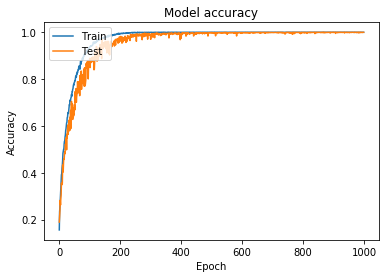

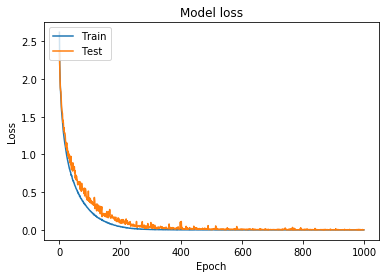

In [15]:
# Plot training & validation accuracy values (of first char only)
plt.plot(history.history['output_0_acc'])
plt.plot(history.history['val_output_0_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values (of first char only)
plt.plot(history.history['output_0_loss'])
plt.plot(history.history['val_output_0_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()